# 0. Setting the scene

In [1]:
# 1. 패키지 설치 (Colab이라면 실행)
!pip install squarify
!pip install category_encoders
!pip install catboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [2]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split


# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

# 1. Loading & checking dataset

In [3]:
import os
# Kaggle 인증 정보 직접 입력 (실제 값으로 바꿔주세요)
os.environ['KAGGLE_USERNAME'] = 'YOURUSERNAME'  # 실제 kaggle 유저명
os.environ['KAGGLE_KEY'] = 'YOURAPIKEY'        # 실제 API 키

# Kaggle API 사용
import kaggle
kaggle.api.authenticate()

# 데이터 다운로드 (unzip 파라미터 제거)
kaggle.api.competition_download_files('playground-series-s4e11')

# 수동으로 압축 해제
import zipfile
with zipfile.ZipFile('playground-series-s4e11.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
# 현재 폴더의 파일들 확인
print("현재 폴더의 파일들:")
for file in os.listdir('.'):
    print(f"- {file}")

현재 폴더의 파일들:
- .config
- test.csv
- train.csv
- playground-series-s4e11.zip
- sample_submission.csv
- sample_data


In [5]:
# 데이터 로드 및 확인
if 'train.csv' in os.listdir('.'):
    train_df = pd.read_csv('train.csv')
    print("Train 데이터 shape:", train_df.shape)
    print("\nTrain 데이터 첫 5행:")
    print(train_df.head())

if 'test.csv' in os.listdir('.'):
    test_df = pd.read_csv('test.csv')
    print(f"\nTest 데이터 shape: {test_df.shape}")

Train 데이터 shape: (140700, 20)

Train 데이터 첫 5행:
   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0               

In [6]:
train_df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

In [9]:
train_df.duplicated().value_counts()

,count
False,140700


In [10]:
train_df.duplicated().value_counts()

,count
False,140700


In [11]:
print(train_df['Have you ever had suicidal thoughts ?'].unique())

['No' 'Yes']


In [12]:
print(train_df['Gender'].unique())

['Female' 'Male']


In [13]:
print(train_df['Degree'].unique())

['BHM' 'LLB' 'B.Pharm' 'BBA' 'MCA' 'MD' 'BSc' 'ME' 'B.Arch' 'BCA' 'BE'
 'MA' 'B.Ed' 'B.Com' 'MBA' 'M.Com' 'MHM' 'BA' 'Class 12' 'M.Tech' 'PhD'
 'M.Ed' 'MSc' 'B.Tech' 'LLM' 'MBBS' 'M.Pharm' 'UX/UI Designer' 'MPA' 'BH'
 'Nalini' 'BEd' 'B.Sc' 'Veda' 'Bhopal' 'S.Tech' 'Degree' '20' 'Class 11'
 'H_Pharm' 'M' 'P.Com' 'BPharm' 'Business Analyst' 'M.Arch' 'LL.Com'
 'Data Scientist' 'MPharm' 'L.Ed' 'P.Pharm' 'Kalyan' 'Unite' 'BArch'
 'HR Manager' 'Badhya' 'S.Pharm' 'LLBA' 'Vrinda' 'M. Business Analyst'
 'Bhavesh' '0' 'LLCom' '29' 'MTech' 'Vivaan' 'BPA' 'Plumber' '5.61' 'Brit'
 'B.03' 'Ritik' '5.56' 'MEd' 'B' 'B BA' '7.06' 'B.B.Arch' 'ACA' 'Brithika'
 'CGPA' '24' 'M_Tech' 'Pihu' 'BB' 'Jhanvi' 'LLTech' 'Aarav' 'Entrepreneur'
 '8.56' 'LHM' 'Lata' 'S.Arch' 'Marsh' 'HCA' '5.88' 'B.Student' 'LL B.Ed'
 'M.S' 'Navya' 'Mahika' nan 'K.Ed' 'B.3.79' 'Mthanya'
 'Working Professional' 'Esha' 'LLS' 'LLEd' 'E.Tech' 'Doctor' 'N.Pharm'
 'LCA' 'B B.Com' 'RCA' 'Mihir' 'Advait']


In [14]:
train_df.isnull().sum()

,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,36630
Academic Pressure,112803
Work Pressure,27918
CGPA,112802


In [15]:
# Backup the original train dataframe
train_original = train_df.copy()

In [16]:
train_df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [17]:
test_df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
count,93800.000000,93800.000000,18767.000000,75022.000000,18766.000000,18767.000000,75026.00000,93800.000000,93800.000000
mean,187599.500000,40.321685,3.158576,3.011797,7.674016,2.939522,2.96092,6.247335,2.978763
std,27077.871962,12.393480,1.386666,1.403563,1.465056,1.374242,1.41071,3.858191,1.414604
min,140700.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.00000,0.000000,1.000000
25%,164149.750000,29.000000,2.000000,2.000000,6.330000,2.000000,2.00000,3.000000,2.000000
50%,187599.500000,42.000000,3.000000,3.000000,7.800000,3.000000,3.00000,6.000000,3.000000
75%,211049.250000,51.000000,4.000000,4.000000,8.940000,4.000000,4.00000,10.000000,4.000000
max,234499.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.00000,12.000000,5.000000


# 2. Survey Data preprocessing

## 2.1. Age

In [18]:
# 1. 연령 구간 설정
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
labels = list(range(1, len(bins)))  # [1, 2, ..., 9]

# 2. pd.cut으로 정수형 레이블 부여
train_df['Age_Encoded'] = pd.cut(
    train_df['Age'],
    bins=bins,
    labels=labels,
    right=True  # (a, b] 오른쪽 포함
)

# 3. pd.cut으로 정수형 레이블 부여
test_df['Age_Encoded'] = pd.cut(
    test_df['Age'],
    bins=bins,
    labels=labels,
    right=True  # (a, b] 오른쪽 포함
)

# 4. NaN이 있을 수 있으므로 정수형으로 변환하기 전에 float으로 먼저 캐스팅 → NaN → 0
train_df['Age_Encoded'] = train_df['Age_Encoded'].astype(float).fillna(0).astype(int)
test_df['Age_Encoded'] = test_df['Age_Encoded'].astype(float).fillna(0).astype(int)

# 5. 확인
print(train_df['Age_Encoded'].value_counts().sort_index())

Age_Encoded
1    10070
2    13994
3    13068
4    12897
5    16347
6    17141
7    20512
8    17816
9    18855
Name: count, dtype: int64


In [19]:
# 5. 확인
print(test_df['Age_Encoded'].value_counts().sort_index())

Age_Encoded
1     6680
2     9466
3     8886
4     8670
5    10768
6    11465
7    13663
8    11661
9    12541
Name: count, dtype: int64


In [20]:
train_df['Age'] = train_df['Age_Encoded']
train_df.drop(columns=['Age_Encoded'], inplace=True)

In [21]:
test_df['Age'] = test_df['Age_Encoded']
test_df.drop(columns=['Age_Encoded'], inplace=True)

## 2.2. CGPA

In [22]:
print(train_df['CGPA'].unique())

[    nan  8.97    5.9     7.03    5.59    8.13    5.7     9.54    8.04
  9.79    8.38    6.1     7.04    8.52    5.64    8.58    6.51    7.25
  7.83    9.93    8.74    6.73    5.57    8.59    7.1     6.08    5.74
  9.86    6.7     6.21    5.87    6.37    9.72    5.88    9.56    6.99
  5.24    9.21    7.85    6.95    5.86    7.92    9.66    8.94    9.71
  7.87    5.6     7.9     5.46    6.79    8.7     7.38    8.5     7.09
  9.82    8.89    7.94    9.11    6.75    7.53    9.49    9.01    7.64
  5.27    6.      9.44    5.75    7.51    9.05    6.38    8.95    9.88
  5.32    6.27    7.7     8.1     9.59    8.96    5.51    7.43    8.79
  9.95    5.37    6.86    8.32    9.74    5.66    7.48    8.23    8.81
  6.03    5.56    5.68    5.14    7.61    6.17    8.17    9.87    8.75
  6.16    9.5     7.99    5.67    8.92    6.19    5.76    6.25    5.11
  5.58    5.65    9.89    8.03    6.61    9.41    8.64    7.21    8.28
  6.04    9.13    8.08    9.96    5.12    8.35    7.07    9.6     9.24
  8.54

In [23]:
# 0 이상 10 이하를 1점 단위로 나눔 → 총 10구간
bins = np.arange(0, 11, 1)  # [0, 1, 2, ..., 10]
labels = list(range(len(bins) - 1))  # [0, 1, 2, ..., 9]

# 구간 인코딩: [0,1), [1,2), ..., [9,10)
train_df['CGPA_Encoded'] = pd.cut(
    train_df['CGPA'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True  # 0 포함
)

# 구간 인코딩: [0,1), [1,2), ..., [9,10)
test_df['CGPA_Encoded'] = pd.cut(
    test_df['CGPA'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True  # 0 포함
)

# NaN → 0 처리 후 정수 변환
train_df['CGPA_Encoded'] = train_df['CGPA_Encoded'].astype(float).fillna(0).astype(int)
test_df['CGPA_Encoded'] = test_df['CGPA_Encoded'].astype(float).fillna(0).astype(int)

# 확인
print(train_df['CGPA_Encoded'].value_counts().sort_index())

CGPA_Encoded
0    112860
5      5404
6      4311
7      5543
8      6407
9      6175
Name: count, dtype: int64


In [24]:
train_df['CGPA'] = train_df['CGPA_Encoded']
train_df.drop(columns=['CGPA_Encoded'], inplace=True)

In [25]:
test_df['CGPA'] = test_df['CGPA_Encoded']
test_df.drop(columns=['CGPA_Encoded'], inplace=True)

## 2.3 Gender


In [26]:
train_df['Female'] = (train_df['Gender'] == 'Female').astype(int)
test_df['Female'] = (test_df['Gender'] == 'Female').astype(int)

train_df['Male'] = (train_df['Gender'] == 'Male').astype(int)
test_df['Male'] = (test_df['Gender'] == 'Male').astype(int)

## 2.4 Have you ever had suicidal thoughts ?, Family History of Mental Illness

In [27]:
Suicide_map = {'Yes': 1, 'No': 0}
train_df['Have you ever had suicidal thoughts?'] = train_df['Have you ever had suicidal thoughts ?'].map(Suicide_map)
test_df['Have you ever had suicidal thoughts?'] = test_df['Have you ever had suicidal thoughts ?'].map(Suicide_map)

Family_map = {'Yes': 1, 'No': 0}
train_df['Family History of Mental Illness'] = train_df['Family History of Mental Illness'].map(Family_map)
test_df['Family History of Mental Illness'] = test_df['Family History of Mental Illness'].map(Family_map)

In [28]:
print(train_df['Have you ever had suicidal thoughts?'].unique())
print(train_df['Family History of Mental Illness'].unique())

[0 1]
[0 1]


In [29]:
print(test_df['Have you ever had suicidal thoughts?'].unique())
print(test_df['Family History of Mental Illness'].unique())

[0 1]
[1 0]


In [30]:
train_df['Suicidal Thoughts'] = train_df['Have you ever had suicidal thoughts?']
test_df['Suicidal Thoughts'] = test_df['Have you ever had suicidal thoughts?']

train_df.drop(columns=['Have you ever had suicidal thoughts?'], inplace=True)
test_df.drop(columns=['Have you ever had suicidal thoughts?'], inplace=True)

## 2.5 Profession

In [31]:
train_df['Working Professional'] = (train_df['Working Professional or Student'] == 'Working Professional').astype(int)
test_df['Working Professional'] = (test_df['Working Professional or Student'] == 'Working Professional').astype(int)

train_df['Student'] = (train_df['Working Professional or Student'] == 'Student').astype(int)
test_df['Student'] = (test_df['Working Professional or Student'] == 'Student').astype(int)

train_df['Working Professional'] = (train_df['Working Professional or Student'] == 'Working Professional').astype(int)
test_df['Working Professional'] = (test_df['Working Professional or Student'] == 'Working Professional').astype(int)

In [32]:
print(train_df['Profession'].unique())

['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist' 'Financial Analyst' 'Architect'
 'Mechanical Engineer' 'Customer Support' 'Consultant' 'Judge'
 'Researcher' 'Pilot' 'Graphic Designer' 'Travel Consultant'
 'Digital Marketer' 'Lawyer' 'Research Analyst' 'Sales Executive' 'Doctor'
 'Unemployed' 'Investment Banker' 'Family Consultant' 'B.Com' 'BE'
 'Student' 'Yogesh' 'Dev' 'MBA' 'LLM' 'BCA' 'Academic' 'Profession'
 'FamilyVirar' 'City Manager' 'BBA' 'Medical Doctor'
 'Working Professional' 'MBBS' 'Patna' 'Unveil' 'B.Ed' 'Nagpur' 'Moderate'
 'M.Ed' 'Analyst' 'Pranav' 'Visakhapatnam' 'PhD' 'Yuvraj']


In [33]:
# Feature engineering: map 'Profession' to simplified categories (1: noise, 2: unemployed/student, 3: valid professions)
profession_map = {
    'nan': 0,
    # Noise or invalid entries
    'Yogesh': 1, 'Dev': 1, 'Patna': 1, 'Pranav': 1, 'Unveil': 1, 'Nagpur': 1,
    'Visakhapatnam': 1, 'Yuvraj': 1, 'Moderate': 1,
    'Profession': 1, 'FamilyVirar': 1,

    # Unemployed or student - 학위만 써낸 경우는 학생으로 간주하엿음
    'Unemployed': 2, 'Student': 2, 'Working Professional': 2, 'MBA': 2, 'LLM': 2, 'PhD': 2, 'BBA': 2,
    'B.Ed': 2, 'B.Com': 2, 'BCA': 2, 'BE': 2, 'M.Ed': 2,

    # Valid professions
    'Chef': 3, 'Teacher': 3, 'Electrician': 3, 'Plumber': 3, 'Customer Support': 3,
    'UX/UI Designer': 3, 'Educational Consultant': 3, 'City Manager': 3, 'Travel Consultant': 3, 'Graphic Designer': 3, 'Digital Marketer': 3,
    'Manager': 3, 'Content Writer': 3, 'Sales Executive': 3, 'Marketing Manager': 3, 'HR Manager': 3,

    #Knowledge workers
    'Doctor': 4, 'Medical Doctor': 4, 'Lawyer': 4,
    'Judge': 4, 'Pharmacist': 4, 'Pilot': 4, 'Civil Engineer': 4, 'Architect': 4, 'Mechanical Engineer': 4,
    'Financial Analyst': 4, 'Software Engineer': 4, 'Academic': 1,
    'Accountant': 4, 'Consultant': 2, 'Research Analyst': 4,
    'Investment Banker': 4, 'Business Analyst': 4, 'Researcher': 4
}

train_df['Profession'] = train_df['Profession'].map(profession_map)
test_df['Profession'] = test_df['Profession'].map(profession_map)

In [34]:
print(train_df['Profession'].unique())
print(test_df['Profession'].unique())

[ 3. nan  4.  2.  1.]
[ 4.  3. nan  2.  1.]


In [35]:
train_df['Profession'][train_df['Profession'].isna()].unique()
test_df['Profession'][test_df['Profession'].isna()].unique()

array([nan])

In [36]:
train_df['Profession'] = train_df['Profession'].astype(float).fillna(0).astype(int)
test_df['Profession'] = test_df['Profession'].astype(float).fillna(0).astype(int)

## 2.6 Sleeping Duration

In [37]:
sleep_mapping = {
    'More than 8 hours': 9.0,
    'Less than 5 hours': 4.5,
    'than 5 hours': 4.5,
    '5-6 hours': 5.5,
    '6-7 hours': 7.5,
    '6-8 hours': 7.5,
    '7-8 hours': 7.5,
    '8-9 hours': 9.0,
    '9-11 hours': 9.0,
    '10-11 hours': 9.0,
    '9-5': 7.5,
    '9-5 hours': 7.5,
    '10-6 hours': 9.0,
    '1-2 hours': 4.5,
    '2-3 hours': 4.5,
    '3-4 hours': 4.5,
    '4-5 hours': 4.5,
    '4-6 hours': 5.5,
    '1-3 hours': 4.5,
    '3-6 hours': 4.5,
    '1-6 hours': 4.5,
    '8 hours': 7.5,
    '45': 7.5,
    '49 hours': 7.5,
    '35-36 hours': 5.5,
    '40-45 hours': 7.5,
    '45-48 hours': 7.5,
    '55-66 hours': 9.0,
}

In [38]:
train_df['Sleep Hours'] = train_df['Sleep Duration'].map(sleep_mapping)
test_df['Sleep Hours'] = test_df['Sleep Duration'].map(sleep_mapping)

In [39]:
train_df['Sleep Duration'] = train_df['Sleep Hours'].fillna(7.5)
test_df['Sleep Duration'] = test_df['Sleep Hours'].fillna(7.5)

## 2.7 Dietary Habits

In [40]:
print(train_df['Dietary Habits'].unique())

['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Gender' '3'
 'More Healthy' 'Less than Healthy' 'Mihir' '1.0' 'Hormonal' 'Electrician'
 nan 'No Healthy' 'Less Healthy' 'M.Tech' 'Vegas' 'No' 'Male' 'Indoor'
 'Class 12' '2']


In [41]:
diet_map = {
    'Healthy': 3,
    'More Healthy': 3,

    'Unhealthy': 1,
    'Less Healthy': 1,
    'No Healthy': 1,
    'Hormonal': 1,

    'Moderate': 2,
    'Less than Healthy': 2
}
# healthy :3 , unhealthy: 1, moderate: 2
# 정제된 컬럼 생성
train_df['Dietary_Category'] = train_df['Dietary Habits'].map(diet_map)
test_df['Dietary_Category'] = test_df['Dietary Habits'].map(diet_map)

In [42]:
print(train_df['Dietary_Category'].isna().sum())
print(test_df['Dietary_Category'].isna().sum())

21
27


In [43]:
train_df['Dietary_Category'] = train_df['Dietary_Category'].fillna(2)
test_df['Dietary_Category'] = test_df['Dietary_Category'].fillna(2)

## 2.8. Degree

In [44]:
# Feature engineering: map 'Degree' to academic levels (0: noise/unknown, 1: high school or below, 2: bachelor's, 3: master's, 4: doctorate/medical)
degree_map = {
    # Noise / invalid / misc
    '0': 0, '20': 0, '24': 0, '29': 0, '5.56': 0, '5.61': 0, '5.88': 0, '7.06': 0, '8.56': 0,
    'Brit': 0, 'CGPA': 0, 'Esha': 0, 'Mihir': 0, 'Navya': 0, 'Advait': 0, 'Jhanvi': 0, 'Aarav': 0,
    'Vivaan': 0, 'Mahika': 0, 'Pihu': 0, 'Lata': 0, 'Veda': 0, 'Nalini': 0, 'Working Professional': 0,
    'Business Analyst': 0, 'Doctor': 0, 'Entrepreneur': 0, 'Ritik': 0, 'Bhopal': 0, 'Indore': 0, 'Pune': 0,
    'Bhavesh': 0, 'Vrinda': 0, 'Mthanya': 0,
    'H_Pharm': 0, 'P.Com': 0, 'P.Pharm': 0, 'S.Tech': 0, 'S.Arch': 0, 'S.Pharm': 0,
    'K.Ed': 0, 'N.Pharm': 0, 'RCA': 0, 'ACA': 0, 'Marsh': 0, 'Brithika': 0, 'Badhya': 0,
    'ME': 0, 'MBBS': 4, 'UX/UI Designer': 0, 'BH': 0, 'Degree': 0, 'M': 0,
    'Data Scientist': 0, 'Kalyan': 0, 'Unite': 0, 'HR Manager': 0, 'Plumber': 0, 'B': 0,
    'M_Tech': 0, 'BB': 0, 'HCA': 0, 'B.Student': 0, 'E.Tech': 0,

    # High school or below
    'Class 11': 1, 'Class 12': 1, 'Diploma': 1, 'High School': 1,

    # Bachelor's
    'BA': 2, 'B.A': 2, 'BSc': 2, 'B.Sc': 2, 'B.Com': 2, 'BEd': 2, 'B.Ed': 2, 'BBA': 2, 'BHM': 2,
    'B.Arch': 2, 'BCA': 2, 'BE': 2, 'B.Tech': 2, 'BPharm': 2, 'B.Pharm': 2, 'BArch': 2, 'BStudent': 2,
    'B.B.Arch': 2, 'B BA': 2, 'B.03': 2, 'B.3.79': 2, 'BPA': 2, 'B B.Com': 2,

    # Master's
    'MA': 3, 'M.A': 3, 'MBA': 3, 'M.Com': 3, 'MHM': 3, 'M.Tech': 3, 'MTech': 3, 'MCA': 3,
    'MSc': 3, 'M.Sc': 3, 'MPA': 3, 'MPharm': 3, 'M.Pharm': 3, 'M.S': 3,
    'M.Ed': 3, 'MEd': 3, 'M.Arch': 3, 'M. Business Analyst': 3,

    # Doctorate or medical
    'PhD': 4, 'Doctorate': 4, 'MD': 4, 'LLB': 4, 'LLM': 4, 'LL.Com': 4, 'LLCom': 4, 'LLBA': 4, 'LLTech': 4,
    'LHM': 4, 'LCA': 4, 'LLEd': 4, 'L.Ed': 4, 'LL B.Ed': 4, 'LLS': 4
}

# Apply mapping
train_df['Degree Encoded'] = train_df['Degree'].map(degree_map)
test_df['Degree Encoded'] = test_df['Degree'].map(degree_map)

In [45]:
print(train_df['Degree Encoded'].unique())

[ 2.  4.  3.  0.  1. nan]


In [46]:
train_df['Degree'] = train_df['Degree Encoded'].fillna(-1)
test_df['Degree'] = test_df['Degree Encoded'].fillna(-1)

In [47]:
# Drop intermediate column
train_df = train_df.drop(columns=['Degree Encoded'])
test_df = test_df.drop(columns=['Degree Encoded'])

## 2.9 Green Space Per Capita

In [48]:
green_space_per_capita = {
    'Ludhiana': 0.8,
    'Varanasi': 24.78,
    'Visakhapatnam': 0.18,
    'Mumbai': 9.36,
    'Kanpur': 1.3,
    'Ahmedabad': 9.38,
    'Thane': 35,
    'Nashik': 8,
    'Bangalore': 3.31,
    'Patna': 2,
    'Rajkot': 15,
    'Jaipur': 6.67,
    'Pune': 17,
    'Lucknow': 7,
    'Meerut': 3,
    'Agra': 18,
    'Surat': 5.90,
    'Faridabad': 3,
    'Hyderabad': 8.2,
    'Srinagar': 2.6,
    'Ghaziabad': 1.5,
    'Kolkata': 6.61,
    'Chennai': 18.05,
    'Kalyan': 2,
    'Nagpur': 17.49,
    'Vadodara': 8,
    'Vasai-Virar': 15,
    'Delhi': 10.41,
    'Bhopal': 18.62,
    'Indore': 20,
    'Morena': 30
}

population_density = {
    'Ludhiana': 9781,
    'Varanasi': 2367,
    'Visakhapatnam': 3900,
    'Mumbai': 20482,
    'Kanpur': 14449,
    'Ahmedabad': 11975,
    'Thane': 11500,
    'Nashik': 5872,
    'Bangalore': 4381,
    'Patna': 11667,
    'Rajkot': 10195,
    'Jaipur': 6491,
    'Pune': 6039,
    'Lucknow': 5459,
    'Meerut': 8493,
    'Agra': 11300,
    'Surat': 13600,
    'Faridabad': 9233,
    'Hyderabad': 10859,
    'Srinagar': 5283,
    'Ghaziabad': 10341,
    'Kolkata': 24306,
    'Chennai': 26903,
    'Kalyan': 11620,
    'Nagpur': 11470,
    'Vadodara': 8775,
    'Vasai-Virar': 9962,
    'Delhi': 11320,
    'Bhopal': 7154,
    'Indore': 11250,
    'Morena': 2340
}

In [49]:
# Map features to train and test datasets
train_df['GreenSpace'] = train_df['City'].map(green_space_per_capita)
train_df['PopulationDensity'] = train_df['City'].map(population_density)

test_df['GreenSpace'] = test_df['City'].map(green_space_per_capita)
test_df['PopulationDensity'] = test_df['City'].map(population_density)

In [50]:
# Fill missing values with column mean
train_df['GreenSpace'].fillna(train_df['GreenSpace'].mean(), inplace=True)
train_df['PopulationDensity'].fillna(train_df['PopulationDensity'].mean(), inplace=True)

test_df['GreenSpace'].fillna(test_df['GreenSpace'].mean(), inplace=True)
test_df['PopulationDensity'].fillna(test_df['PopulationDensity'].mean(), inplace=True)

# 3. EDA

## 3.1. Stress, Sudicidal thoughts and Depression

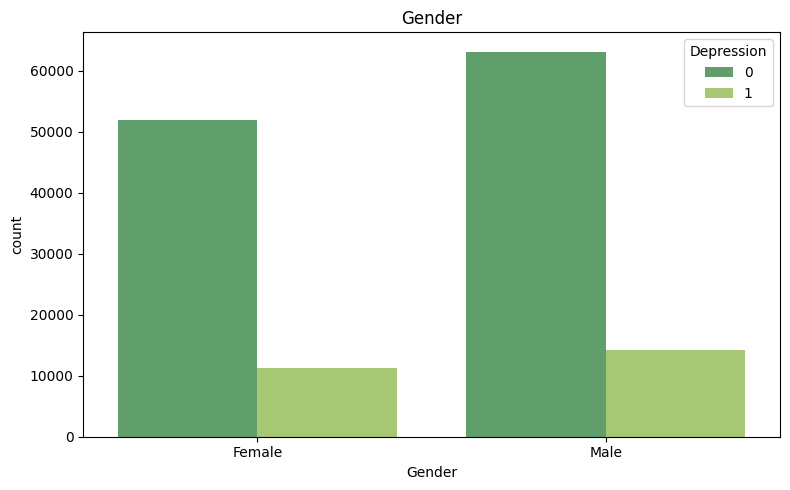

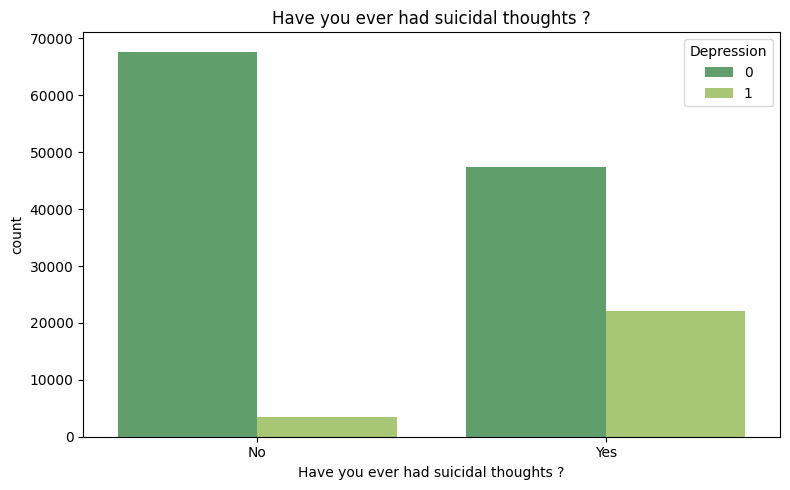

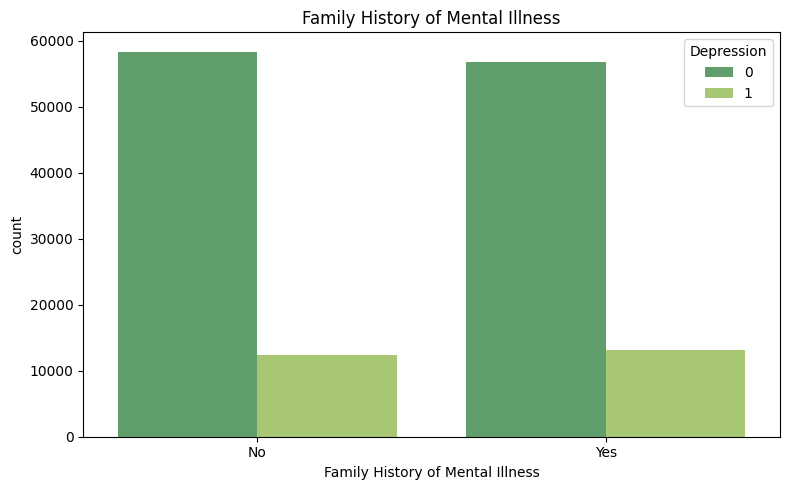

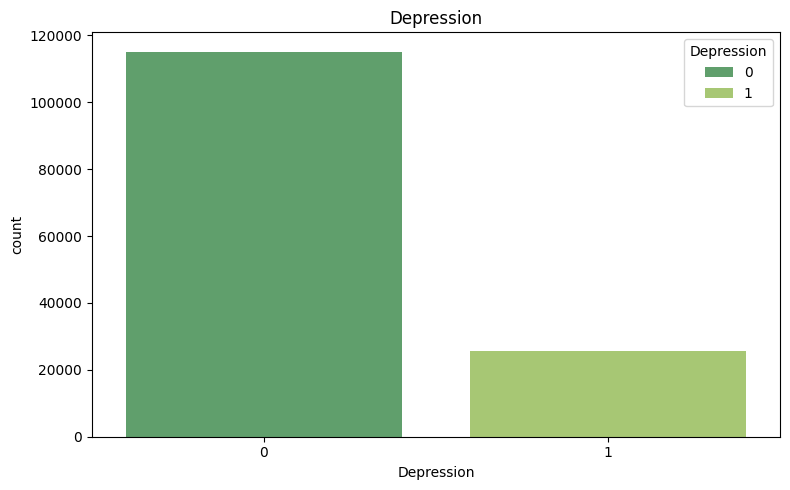

In [51]:
# Countplots for categorical columns with counts and percentages
categorical_columns_to_plot = ['Gender', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Depression']

total = len(train_df)
for column in categorical_columns_to_plot:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=train_original, x=column, palette='summer', hue = 'Depression')
    plt.title(f'{column}')

 # Add count and percentage labels centered lower inside each bar
    for p in ax.patches:
        count = int(p.get_height())
        percent = 100 * count / total

    plt.tight_layout()
    plt.show()


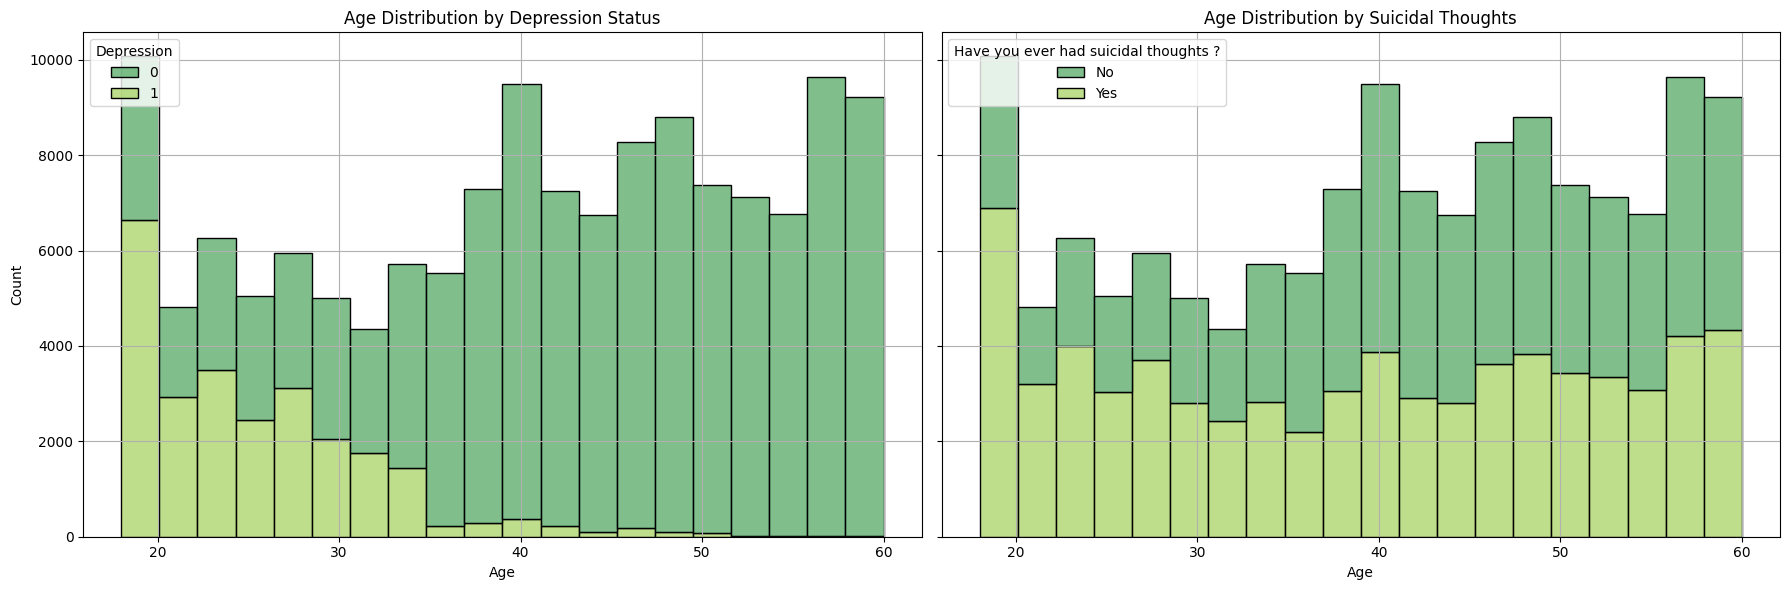

In [52]:
# Set up the subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# 첫 번째 그래프: Depression 여부에 따른 연령 분포
sns.histplot(data=train_original, x='Age', hue='Depression', multiple='stack',
             bins=20, edgecolor='black', palette='summer', ax=axes[0])
axes[0].set_title('Age Distribution by Depression Status')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].grid(True)

# 두 번째 그래프: 자살 생각 여부에 따른 연령 분포
sns.histplot(data=train_original, x='Age', hue='Have you ever had suicidal thoughts ?',
             multiple='stack', bins=20, edgecolor='black', palette='summer', ax=axes[1])
axes[1].set_title('Age Distribution by Suicidal Thoughts')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('')  # sharey=True 이므로 생략 가능
axes[1].grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()


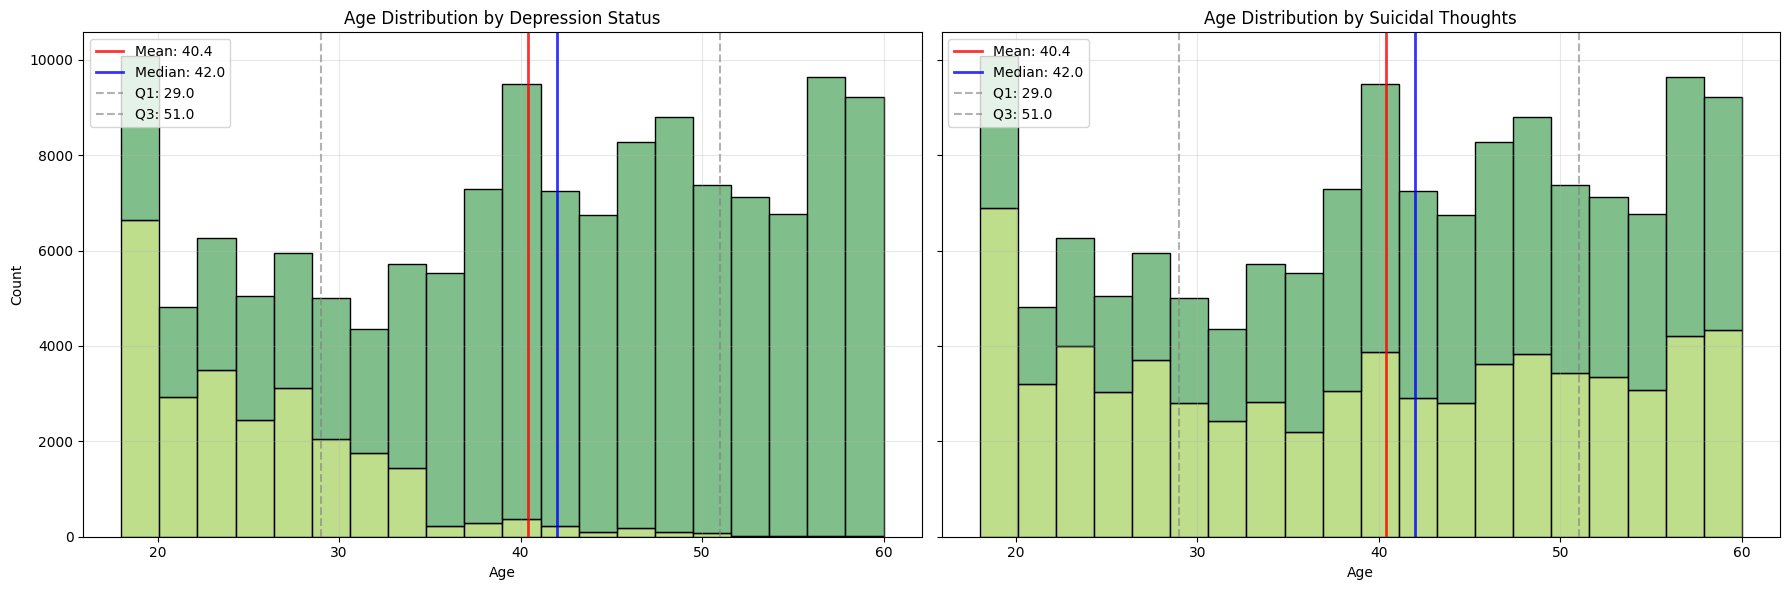

연령 통계:
평균: 40.39세
중앙값: 42.00세
1사분위수: 29.00세
3사분위수: 51.00세


In [53]:
# Set up the subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# 첫 번째 그래프: Depression 여부에 따른 연령 분포
sns.histplot(data=train_original, x='Age', hue='Depression', multiple='stack',
             bins=20, edgecolor='black', palette='summer', ax=axes[0])

# 통계적으로 의미있는 선들 추가
age_mean = train_original['Age'].mean()
age_median = train_original['Age'].median()
age_q1 = train_original['Age'].quantile(0.25)
age_q3 = train_original['Age'].quantile(0.75)

# 평균선 (빨간 실선)
axes[0].axvline(age_mean, color='red', linestyle='-', linewidth=2, alpha=0.8, label=f'Mean: {age_mean:.1f}')
# 중앙값선 (파란 실선)
axes[0].axvline(age_median, color='blue', linestyle='-', linewidth=2, alpha=0.8, label=f'Median: {age_median:.1f}')
# 사분위수선 (회색 점선)
axes[0].axvline(age_q1, color='gray', linestyle='--', alpha=0.6, label=f'Q1: {age_q1:.1f}')
axes[0].axvline(age_q3, color='gray', linestyle='--', alpha=0.6, label=f'Q3: {age_q3:.1f}')

axes[0].set_title('Age Distribution by Depression Status')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)  # 격자는 연하게

# 두 번째 그래프: 자살 생각 여부에 따른 연령 분포
sns.histplot(data=train_original, x='Age', hue='Have you ever had suicidal thoughts ?',
             multiple='stack', bins=20, edgecolor='black', palette='summer', ax=axes[1])

# 동일한 통계선들 추가
axes[1].axvline(age_mean, color='red', linestyle='-', linewidth=2, alpha=0.8, label=f'Mean: {age_mean:.1f}')
axes[1].axvline(age_median, color='blue', linestyle='-', linewidth=2, alpha=0.8, label=f'Median: {age_median:.1f}')
axes[1].axvline(age_q1, color='gray', linestyle='--', alpha=0.6, label=f'Q1: {age_q1:.1f}')
axes[1].axvline(age_q3, color='gray', linestyle='--', alpha=0.6, label=f'Q3: {age_q3:.1f}')

axes[1].set_title('Age Distribution by Suicidal Thoughts')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 정보 출력
print(f"연령 통계:")
print(f"평균: {age_mean:.2f}세")
print(f"중앙값: {age_median:.2f}세")
print(f"1사분위수: {age_q1:.2f}세")
print(f"3사분위수: {age_q3:.2f}세")

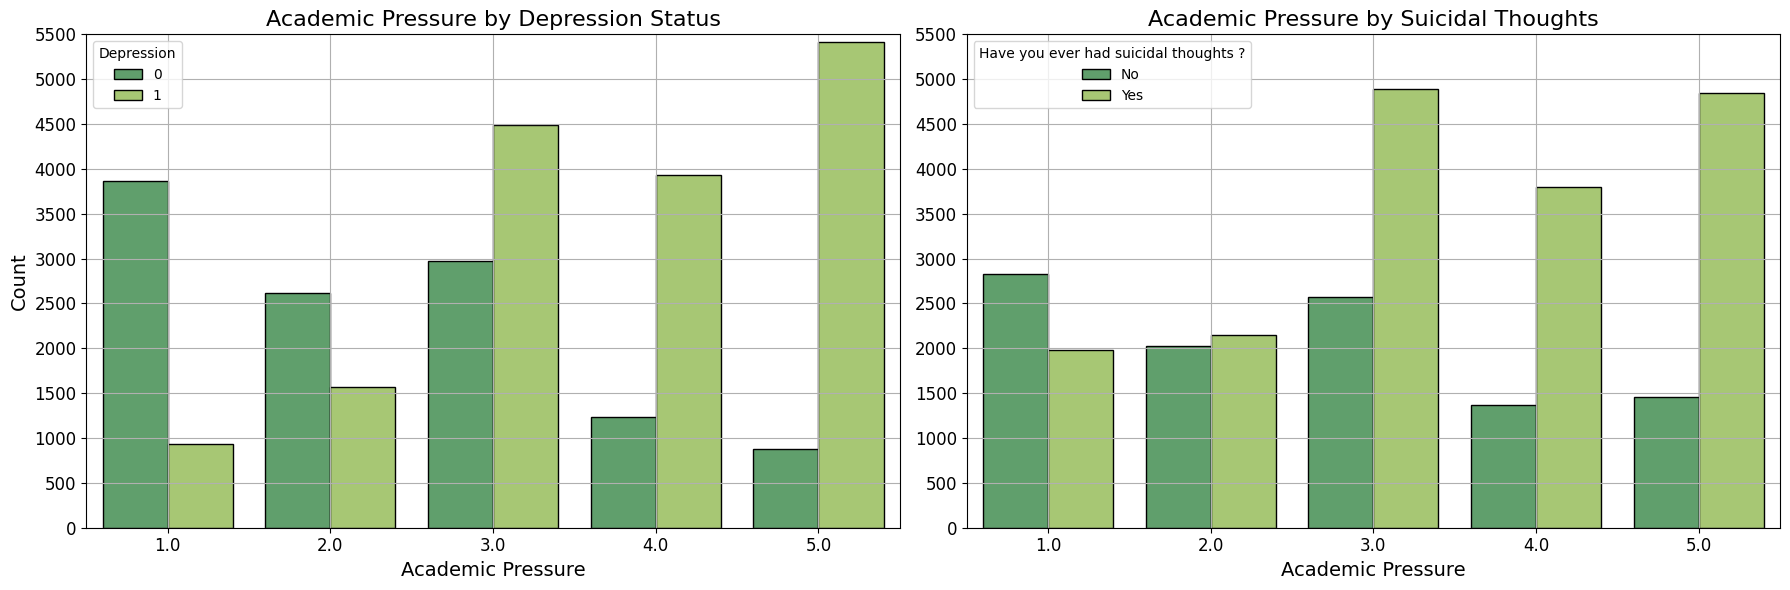

In [54]:
# Set up the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 공통 설정
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
ytick_step = 500  # ✅ y축 단위

# 첫 번째 그래프: 우울 여부
sns.countplot(data=train_original, x='Academic Pressure', hue='Depression',
              edgecolor='black', palette='summer', ax=axes[0])
axes[0].set_title('Academic Pressure by Depression Status', fontsize=title_fontsize)
axes[0].set_xlabel('Academic Pressure', fontsize=label_fontsize)
axes[0].set_ylabel('Count', fontsize=label_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].grid(True)

# 두 번째 그래프: 자살 생각 여부
sns.countplot(data=train_original, x='Academic Pressure', hue='Have you ever had suicidal thoughts ?',
              edgecolor='black', palette='summer', ax=axes[1])
axes[1].set_title('Academic Pressure by Suicidal Thoughts', fontsize=title_fontsize)
axes[1].set_xlabel('Academic Pressure', fontsize=label_fontsize)
axes[1].set_ylabel('', fontsize=label_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].grid(True)

# ✅ 두 그래프의 최댓값을 모두 고려해서 공통 스케일 설정
ymax0 = max([patch.get_height() for patch in axes[0].patches])
ymax1 = max([patch.get_height() for patch in axes[1].patches])
ymax_common = max(ymax0, ymax1)  # 더 큰 값 선택
ymax_common = int(np.ceil(ymax_common / ytick_step)) * ytick_step

# 두 그래프 모두 동일한 y축 범위 적용
for ax in axes:
    ax.set_ylim(0, ymax_common)
    ax.set_yticks(np.arange(0, ymax_common + 1, ytick_step))
    ax.tick_params(axis='y', labelsize=tick_fontsize)

# 레이아웃 정리
plt.tight_layout()
plt.show()

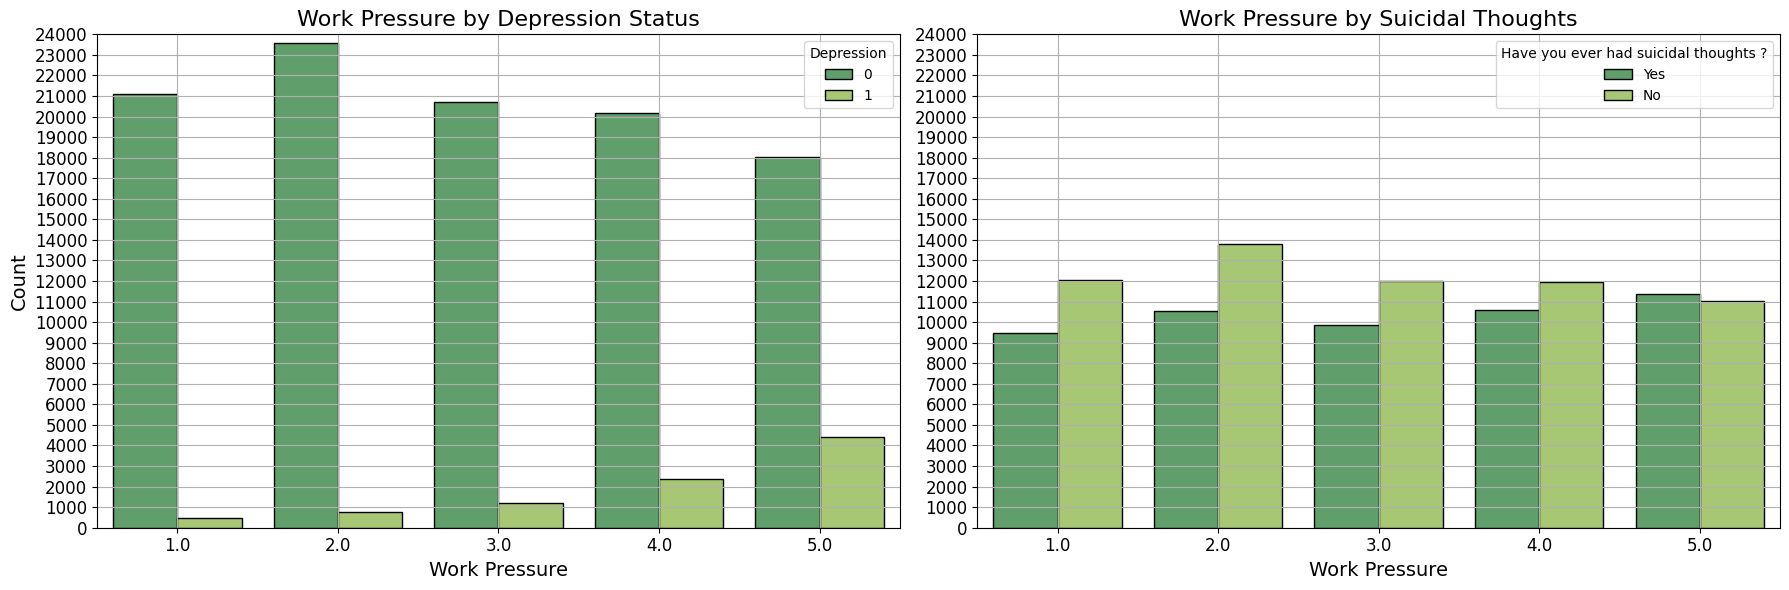

In [55]:
# Set up the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 공통 설정
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
ytick_step = 1000  # ✅ y축 단위

# 첫 번째 그래프: 우울 여부
sns.countplot(data=train_original, x='Work Pressure', hue='Depression',
              edgecolor='black', palette='summer', ax=axes[0])
axes[0].set_title('Work Pressure by Depression Status', fontsize=title_fontsize)
axes[0].set_xlabel('Work Pressure', fontsize=label_fontsize)
axes[0].set_ylabel('Count', fontsize=label_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].grid(True)

# 두 번째 그래프: 자살 생각 여부
sns.countplot(data=train_original, x='Work Pressure', hue='Have you ever had suicidal thoughts ?',
              edgecolor='black', palette='summer', ax=axes[1])
axes[1].set_title('Work Pressure by Suicidal Thoughts', fontsize=title_fontsize)
axes[1].set_xlabel('Work Pressure', fontsize=label_fontsize)
axes[1].set_ylabel('', fontsize=label_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].grid(True)

# ✅ 두 그래프의 최댓값을 모두 고려해서 공통 스케일 설정
ymax0 = max([patch.get_height() for patch in axes[0].patches])
ymax1 = max([patch.get_height() for patch in axes[1].patches])
ymax_common = max(ymax0, ymax1)  # 더 큰 값 선택
ymax_common = int(np.ceil(ymax_common / ytick_step)) * ytick_step

# 두 그래프 모두 동일한 y축 범위 적용
for ax in axes:
    ax.set_ylim(0, ymax_common)
    ax.set_yticks(np.arange(0, ymax_common + 1, ytick_step))
    ax.tick_params(axis='y', labelsize=tick_fontsize)

# 레이아웃 정리
plt.tight_layout()
plt.show()

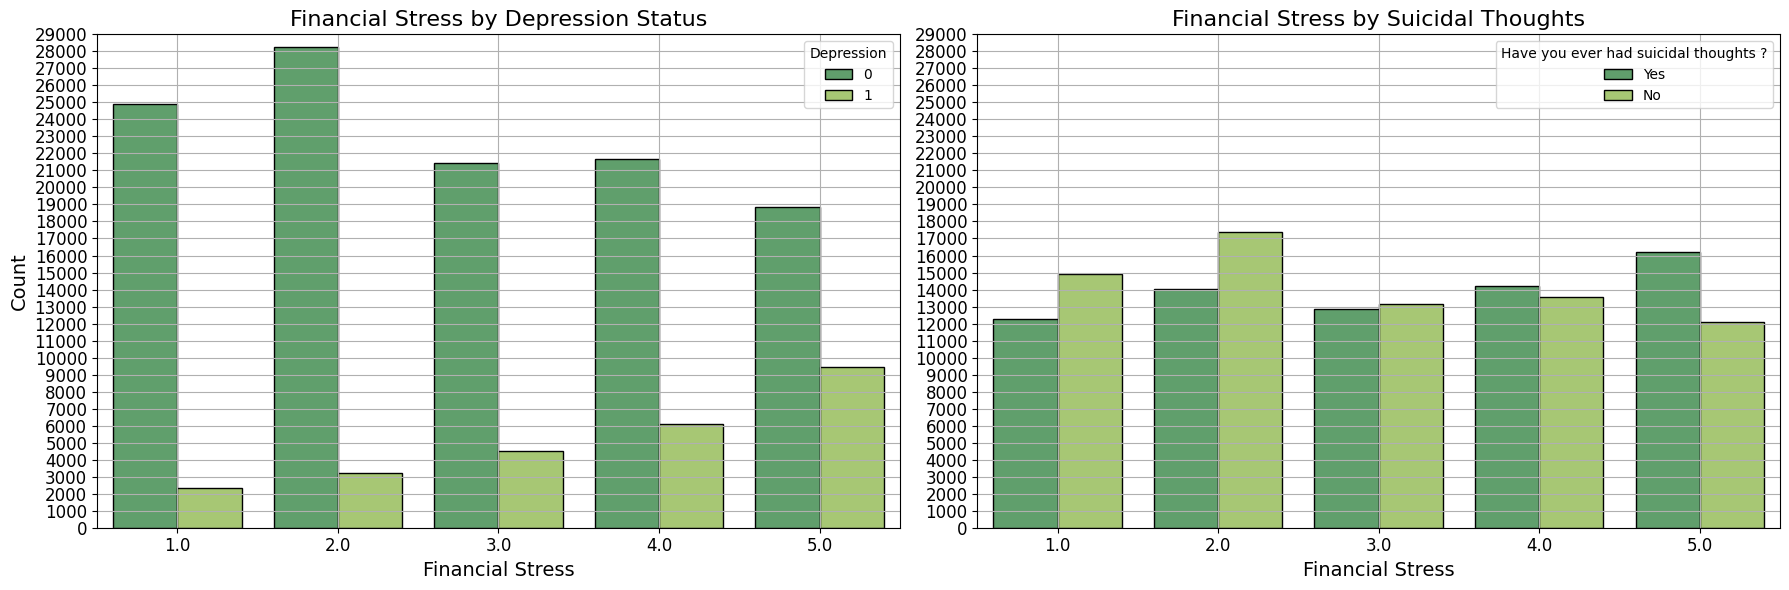

In [56]:
# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 공통 설정값
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
ytick_step = 1000

# 첫 번째 그래프: Financial Stress vs Depression
sns.countplot(data=train_original, x='Financial Stress', hue='Depression',
              edgecolor='black', palette='summer', ax=axes[0])
axes[0].set_title('Financial Stress by Depression Status', fontsize=title_fontsize)
axes[0].set_xlabel('Financial Stress', fontsize=label_fontsize)
axes[0].set_ylabel('Count', fontsize=label_fontsize)
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].grid(True)

# 두 번째 그래프: Financial Stress vs Suicidal Thoughts
sns.countplot(data=train_original, x='Financial Stress', hue='Have you ever had suicidal thoughts ?',
              edgecolor='black', palette='summer', ax=axes[1])
axes[1].set_title('Financial Stress by Suicidal Thoughts', fontsize=title_fontsize)
axes[1].set_xlabel('Financial Stress', fontsize=label_fontsize)
axes[1].set_ylabel('', fontsize=label_fontsize)
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].grid(True)

# ✅ 두 그래프의 최댓값을 모두 고려해서 공통 스케일 설정
ymax0 = max([patch.get_height() for patch in axes[0].patches])
ymax1 = max([patch.get_height() for patch in axes[1].patches])
ymax_common = max(ymax0, ymax1)  # 더 큰 값 선택
ymax_common = int(np.ceil(ymax_common / ytick_step)) * ytick_step

# 두 그래프 모두 동일한 y축 범위 적용
for ax in axes:
    ax.set_ylim(0, ymax_common)
    ax.set_yticks(np.arange(0, ymax_common + 1, ytick_step))
    ax.tick_params(axis='y', labelsize=tick_fontsize)

# 레이아웃 정리
plt.tight_layout()
plt.show()

## 3.2. Sleep and dietary habits

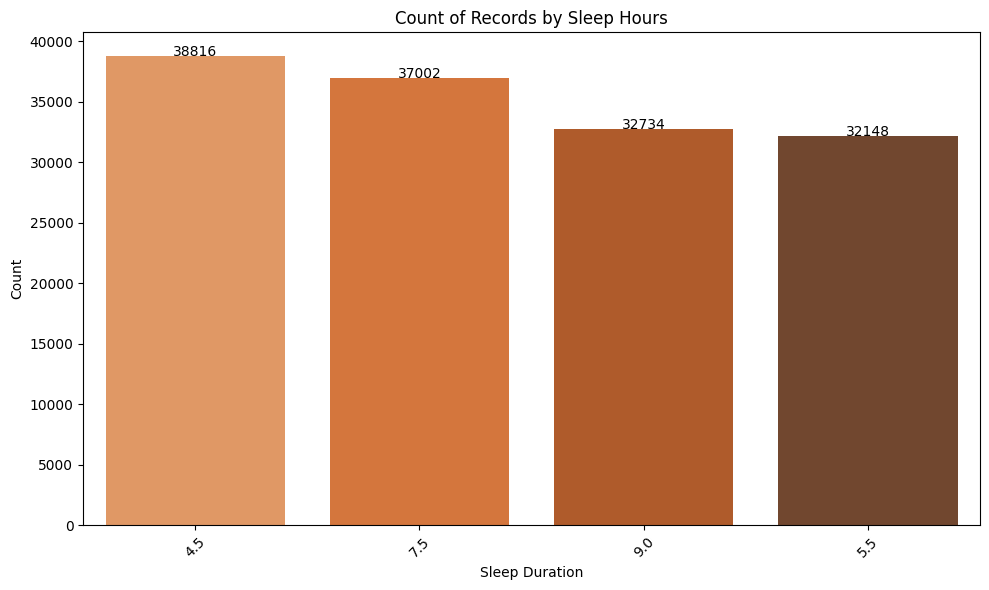

In [57]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df,
                   x='Sleep Duration',
                   order=train_df['Sleep Duration'].value_counts().index,
                   palette='Oranges_d')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,  # 막대의 가운데
            height + 1,                      # 막대 위에 살짝 띄우기
            int(height),                     # 정수형으로 표시
            ha="center", fontsize=10)

plt.title('Count of Records by Sleep Hours')
plt.xlabel('Sleep Duration')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

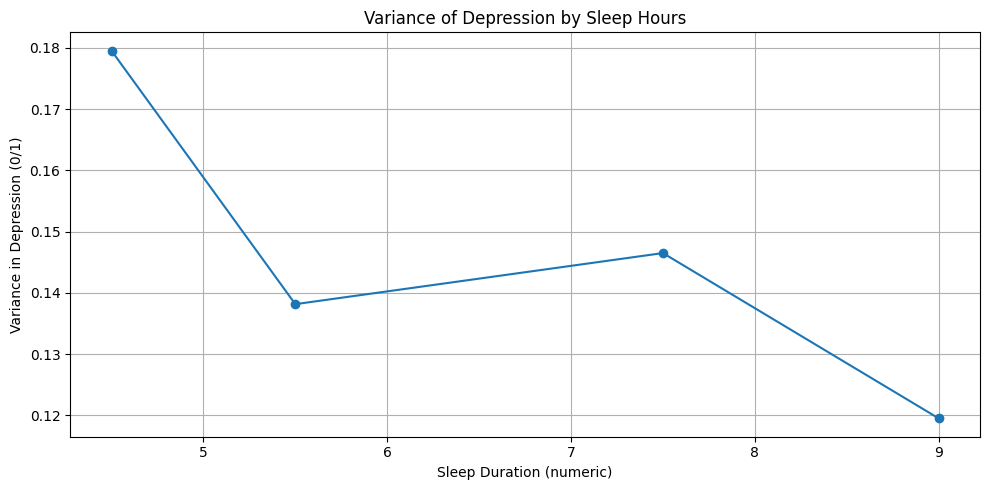

In [58]:
variance_by_sleep_num = train_df.groupby('Sleep Duration')['Depression'].var().sort_index()
plt.figure(figsize=(10, 5))
variance_by_sleep_num.plot(marker='o')
plt.title('Variance of Depression by Sleep Hours')
plt.xlabel('Sleep Duration (numeric)')
plt.ylabel('Variance in Depression (0/1)')
plt.grid(True)
plt.tight_layout()
plt.show()

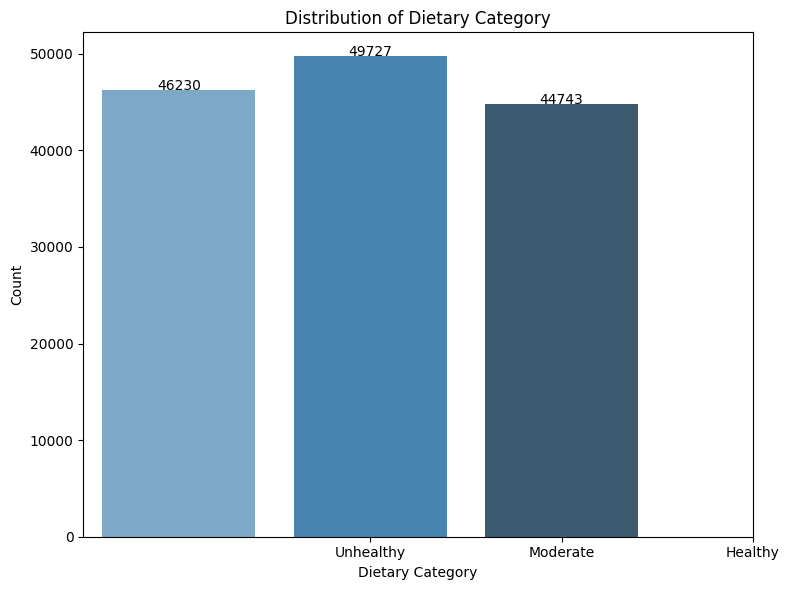

In [59]:
# prompt: Dietary_Category 분포

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_df, x='Dietary_Category', palette='Blues_d')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            int(height),
            ha="center", fontsize=10)

plt.title('Distribution of Dietary Category')
plt.xlabel('Dietary Category')
plt.ylabel('Count')
plt.xticks(ticks=[1, 2, 3], labels=['Unhealthy', 'Moderate', 'Healthy']) # Assuming 1: Unhealthy, 2: Moderate, 3: Healthy based on the mapping
plt.tight_layout()
plt.show()

Proportion of Depression by Dietary Category:
   Dietary_Category  Depression_Proportion
0               1.0               0.260545
1               2.0               0.165725
2               3.0               0.118030


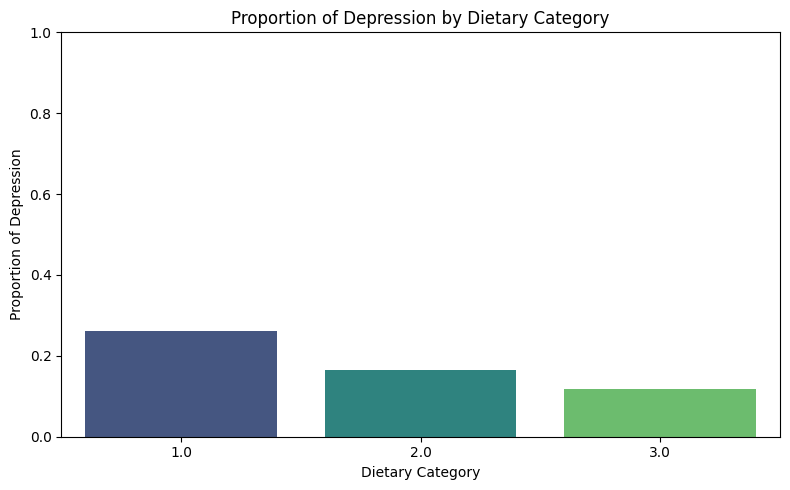

In [60]:
# Group by 'Dietary_Category' and calculate the mean of 'Depression' (which represents the proportion)
depression_proportion_by_diet = train_df.groupby('Dietary_Category')['Depression'].mean().reset_index()

# Rename the 'Depression' column to make it clearer that it's a proportion
depression_proportion_by_diet = depression_proportion_by_diet.rename(columns={'Depression': 'Depression_Proportion'})

print("Proportion of Depression by Dietary Category:")
print(depression_proportion_by_diet)

# Visualize the proportion
plt.figure(figsize=(8, 5))
sns.barplot(x='Dietary_Category', y='Depression_Proportion', data=depression_proportion_by_diet, palette='viridis')
plt.title('Proportion of Depression by Dietary Category')
plt.xlabel('Dietary Category')
plt.ylabel('Proportion of Depression')
plt.ylim(0, 1) # Ensure the y-axis is between 0 and 1 for proportion
plt.tight_layout()
plt.show()

In [61]:
df_ = train_df[['Sleep Hours', 'Dietary_Category', 'Depression']].dropna()

# Sleep Hours를 정수로 반올림하여 그룹화 (예: 6.5 → 6)
df_['Sleep_Hour_Int'] = df_['Sleep Hours'].round().astype(int)

# 그룹별 우울증 비율 계산
grouped = df_.groupby(['Sleep_Hour_Int', 'Dietary_Category'])['Depression'].mean().reset_index()
grouped.rename(columns={'Depression': 'Depression_Rate'}, inplace=True)

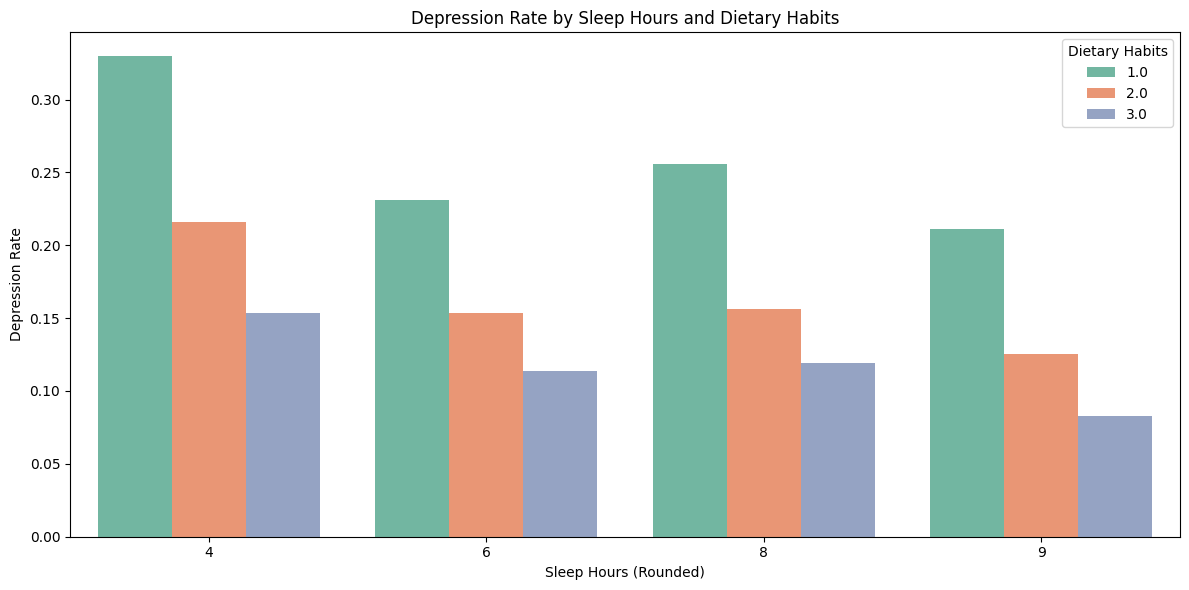

In [62]:
plt.figure(figsize=(12,6))
sns.barplot(data=grouped,
            x='Sleep_Hour_Int',
            y='Depression_Rate',
            hue='Dietary_Category',
            palette='Set2')

plt.title('Depression Rate by Sleep Hours and Dietary Habits')
plt.xlabel('Sleep Hours (Rounded)')
plt.ylabel('Depression Rate')
plt.legend(title='Dietary Habits')
plt.tight_layout()
plt.show()

## 3.3. cities and professions

--- 학생 수가 100명 넘는 도시별 통계 ---
             City  Total_Count  Student_Count  Student_Ratio
17      Hyderabad         4496           1340       0.298043
10       Srinagar         5074           1372       0.270398
21        Lucknow         4280           1155       0.269860
27         Bhopal         3475            934       0.268777
20          Thane         4289           1139       0.265563
19         Jaipur         4328           1036       0.239372
0          Kalyan         6591           1570       0.238204
13           Agra         4684           1094       0.233561
14          Surat         4636           1078       0.232528
2     Vasai-Virar         5765           1290       0.223764
24        Chennai         4044            885       0.218843
26          Delhi         3593            768       0.213749
6        Ludhiana         5226           1111       0.212591
25      Ghaziabad         3620            745       0.205801
3         Kolkata         5689           1066       0.18

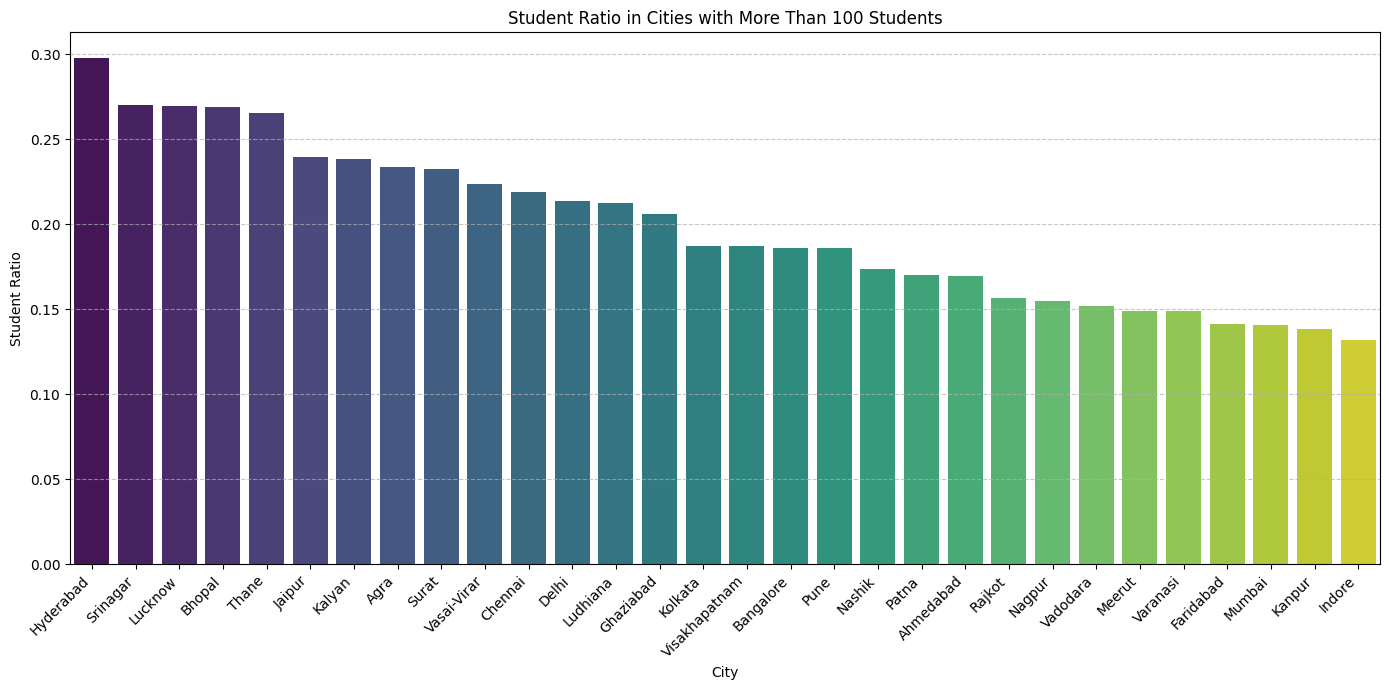

In [63]:
# 1. 도시별 전체 개체 수 계산
city_total_counts = train_df['City'].value_counts().reset_index()
city_total_counts.columns = ['City', 'Total_Count']

# 2. 도시별 학생 수 계산
# 'Working Professional or Student'가 'Student'인 경우만 필터링하여 도시별 카운트 계산
student_counts = train_df[train_df['Working Professional or Student'] == 'Student']['City'].value_counts().reset_index()
student_counts.columns = ['City', 'Student_Count']

# 3. 전체 카운트와 학생 수 카운트 데이터프레임을 도시를 기준으로 병합
city_stats = pd.merge(city_total_counts, student_counts, on='City', how='left')

# 학생 수가 없는 도시는 병합 후 Student_Count가 NaN이 되므로 0으로 채워줍니다.
city_stats['Student_Count'] = city_stats['Student_Count'].fillna(0).astype(int)

# 4. 학생 비율 계산
city_stats['Student_Ratio'] = city_stats['Student_Count'] / city_stats['Total_Count']

# 5. 학생 수가 100명을 넘는 도시만 필터링
filtered_city_stats = city_stats[city_stats['Student_Count'] > 100].sort_values(by='Student_Ratio', ascending=False)


print("--- 학생 수가 100명 넘는 도시별 통계 ---")
print(filtered_city_stats)
print("-" * 30)


# 6. 필터링된 도시의 학생 비율 시각화 (막대 그래프)
if not filtered_city_stats.empty:
    plt.figure(figsize=(14, 7)) # 그래프 크기 설정 (필터링된 도시 수에 따라 조절)
    # 막대 그래프 생성
    sns.barplot(data=filtered_city_stats, x='City', y='Student_Ratio', palette='viridis')

    plt.title('Student Ratio in Cities with More Than 100 Students') # 그래프 제목 설정
    plt.xlabel('City') # x축 레이블 설정
    plt.ylabel('Student Ratio') # y축 레이블 설정
    plt.xticks(rotation=45, ha='right') # 도시 이름이 겹치지 않도록 회전
    plt.grid(axis='y', linestyle='--', alpha=0.7) # y축 그리드 추가
    plt.tight_layout() # 그래프 여백 자동 조절
    plt.show()
else:
    print("학생 수가 100명을 넘는 도시가 없습니다.")

--- 학생 수가 100명 넘는 도시별 학생 비율 및 우울증 비율 ---
             City  Student_Ratio  Student_Count  Depression_Ratio
0          Kalyan       0.238204           1570          0.199666
1           Patna       0.169986           1007          0.163234
2     Vasai-Virar       0.223764           1290          0.197918
3         Kolkata       0.187379           1066          0.173668
4       Ahmedabad       0.169428            951          0.217887
5          Meerut       0.149240            825          0.134045
6        Ludhiana       0.212591           1111          0.192690
7            Pune       0.185797            968          0.161036
8          Rajkot       0.156712            816          0.173228
9   Visakhapatnam       0.187210            969          0.159196
10       Srinagar       0.270398           1372          0.211667
11         Mumbai       0.140757            699          0.131293
12         Indore       0.131979            643          0.160920
13           Agra       0.233561   

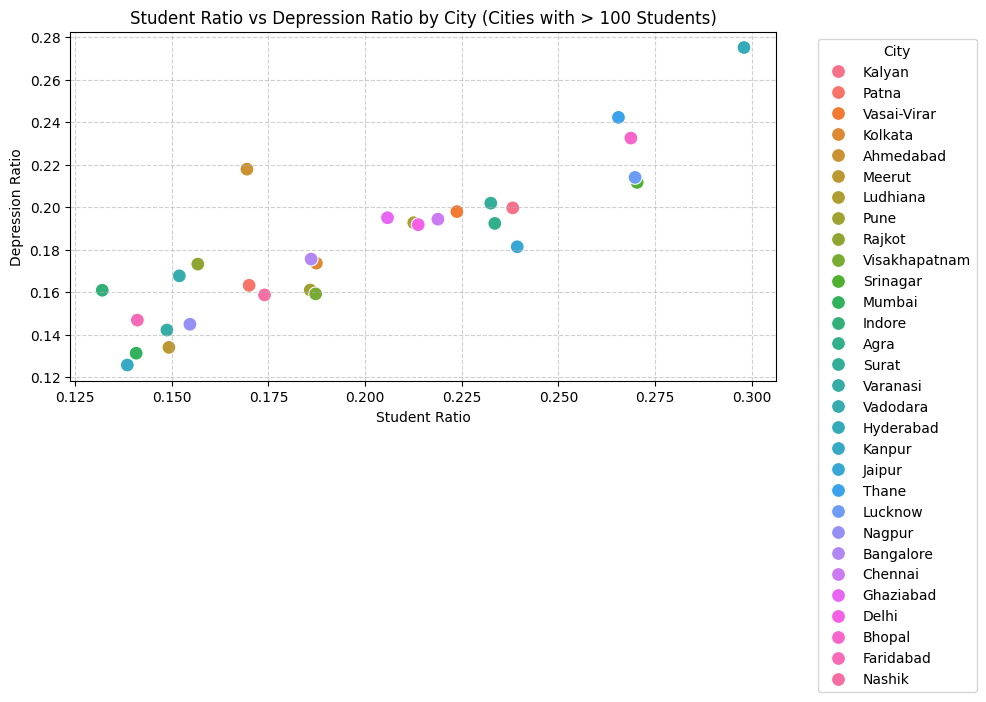

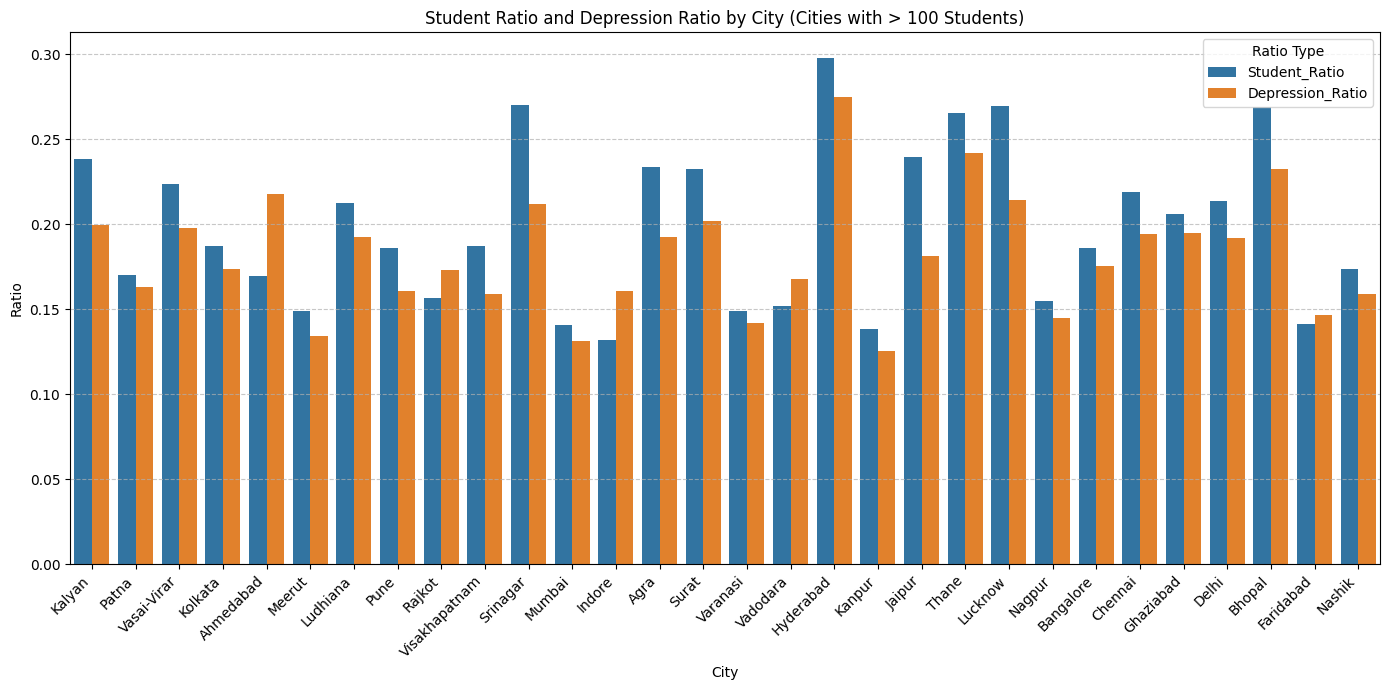

In [64]:
# 1. 도시별 전체 개체 수 계산 (앞서 계산한 city_total_counts 재사용)
city_total_counts = train_df['City'].value_counts().reset_index()
city_total_counts.columns = ['City', 'Total_Count']

# 2. 도시별 우울증 있는 개체 수 계산
# 'Depression'이 1인 경우만 필터링하여 도시별 카운트 계산
depressed_counts = train_df[train_df['Depression'] == 1]['City'].value_counts().reset_index()
depressed_counts.columns = ['City', 'Depressed_Count']

# 3. 도시별 전체 통계와 우울증 통계 병합
city_depression_stats = pd.merge(city_total_counts, depressed_counts, on='City', how='left')

# 우울증 있는 개체가 없는 도시는 병합 후 Depressed_Count가 NaN이 되므로 0으로 채워줍니다.
city_depression_stats['Depressed_Count'] = city_depression_stats['Depressed_Count'].fillna(0).astype(int)

# 4. 도시별 우울증 비율 계산
city_depression_stats['Depression_Ratio'] = city_depression_stats['Depressed_Count'] / city_depression_stats['Total_Count']

# 5. 기존에 계산한 도시별 학생 비율 데이터와 병합
# 앞서 "학생 수가 100명 넘는 도시별 학생 비율 시각화" 코드에서 계산한 city_stats DataFrame이 있다고 가정합니다.
# 만약 city_stats DataFrame이 없다면, 해당 코드를 먼저 실행하여 city_stats를 생성해야 합니다.
# 여기서는 city_stats DataFrame에 이미 'City', 'Total_Count', 'Student_Count', 'Student_Ratio' 컬럼이 있다고 가정합니다.

# 필요한 컬럼만 선택하여 병합
# city_stats는 전체 도시 정보를 포함하고 있으므로, 전체 도시를 기준으로 병합합니다.
# 학생 비율이 100명 넘는 도시 필터링은 시각화 단계에서 수행합니다.
city_combined_stats = pd.merge(city_stats[['City', 'Student_Ratio', 'Student_Count']],
                               city_depression_stats[['City', 'Depression_Ratio']],
                               on='City',
                               how='inner') # 두 데이터 모두에 있는 도시만 선택

# 학생 수가 100명을 넘는 도시만 필터링
filtered_city_combined_stats = city_combined_stats[city_combined_stats['Student_Count'] > 100].copy()

print("--- 학생 수가 100명 넘는 도시별 학생 비율 및 우울증 비율 ---")
print(filtered_city_combined_stats)
print("-" * 30)


# 6. 시각화

# 시각화 방법 1: 산점도 (Scatter Plot)
if not filtered_city_combined_stats.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_city_combined_stats,
                    x='Student_Ratio',
                    y='Depression_Ratio',
                    hue='City', # 도시별로 색상 구분 (도시가 많으면 비효율적일 수 있음)
                    s=100) # 점 크기 설정

    # 도시 이름 표시 (선택 사항, 도시가 많으면 겹칠 수 있음)
    # for i in range(len(filtered_city_combined_stats)):
    #     plt.text(filtered_city_combined_stats['Student_Ratio'].iloc[i] + 0.01,
    #              filtered_city_combined_stats['Depression_Ratio'].iloc[i],
    #              filtered_city_combined_stats['City'].iloc[i],
    #              fontsize=9)

    plt.title('Student Ratio vs Depression Ratio by City (Cities with > 100 Students)')
    plt.xlabel('Student Ratio')
    plt.ylabel('Depression Ratio')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 위치 조정
    plt.tight_layout()
    plt.show()
else:
     print("학생 수가 100명을 넘는 도시가 없습니다.")


# 시각화 방법 2: 결합된 막대 그래프 (Dual Axis Bar Plot 또는 Grouped Bar Plot)
# 두 변수의 스케일이 0-1로 동일하므로 Grouped Bar Plot이 적합합니다.

if not filtered_city_combined_stats.empty:
    # 데이터를 melt하여 seaborn의 barplot으로 그룹화하기 쉽게 만듭니다.
    df_melted = filtered_city_combined_stats.melt(id_vars=['City'],
                                                  value_vars=['Student_Ratio', 'Depression_Ratio'],
                                                  var_name='Ratio_Type',
                                                  value_name='Ratio_Value')

    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_melted,
                x='City',
                y='Ratio_Value',
                hue='Ratio_Type', # 학생 비율 vs 우울증 비율로 그룹화
                palette='tab10') # 다른 색상 팔레트 사용 예시

    plt.title('Student Ratio and Depression Ratio by City (Cities with > 100 Students)')
    plt.xlabel('City')
    plt.ylabel('Ratio')
    plt.xticks(rotation=45, ha='right') # 도시 이름이 겹치지 않도록 회전
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Ratio Type')
    plt.tight_layout()
    plt.show()
else:
    print("학생 수가 100명을 넘는 도시가 없습니다.")

In [65]:
df_students = train_df[train_df['Working Professional or Student'] == 'Student'].copy()
df_students

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,Depression,Female,Male,Suicidal Thoughts,Working Professional,Student,Sleep Hours,Dietary_Category,GreenSpace,PopulationDensity
2,2,Yuvraj,Male,4,Visakhapatnam,Student,0,5.0,NaN,8,...,1,0,1,1,0,1,5.5,3.0,0.18,3900.0
8,8,Aishwarya,Female,2,Bangalore,Student,0,2.0,NaN,5,...,0,1,0,0,0,1,5.5,2.0,3.31,4381.0
26,26,Aditya,Male,4,Srinagar,Student,0,3.0,NaN,7,...,0,0,1,0,0,1,4.5,3.0,2.60,5283.0
30,30,Prisha,Female,3,Varanasi,Student,0,3.0,NaN,5,...,1,1,0,1,0,1,7.5,2.0,24.78,2367.0
32,32,Chhavi,Female,2,Jaipur,Student,0,4.0,NaN,8,...,0,1,0,1,0,1,5.5,2.0,6.67,6491.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,140685,Aaradhya,Female,3,Surat,Student,0,5.0,NaN,5,...,0,1,0,1,0,1,5.5,1.0,5.90,13600.0
140686,140686,Rohan,Male,3,Ludhiana,Student,0,2.0,NaN,9,...,0,0,1,0,0,1,4.5,3.0,0.80,9781.0
140689,140689,Ayaan,Male,4,Faridabad,Student,0,3.0,NaN,6,...,0,0,1,0,0,1,5.5,1.0,3.00,9233.0
140690,140690,Rashi,Female,1,Ludhiana,Student,0,5.0,NaN,6,...,1,1,0,1,0,1,4.5,3.0,0.80,9781.0


# 4. Feacture Engineering

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 29 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  int64  
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  int64  
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   140700 non-null  int64  
 10  Study Satisfaction                     27897 non-null   

In [67]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  int64  
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             93800 non-null  int64  
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   93800 non-null  int64  
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

In [68]:
train_df = train_df.drop(columns=['Sleep Duration', 'Dietary Habits'])


In [69]:
test_df = test_df.drop(columns=['Sleep Duration', 'Dietary Habits'])

In [70]:
train_df = train_df.fillna(0)

In [71]:
test_df = test_df.fillna(0)

In [72]:
from category_encoders.target_encoder import TargetEncoder

# Feature Engineering
train_df['Age_WorkPressure'] = train_df['Age'] * train_df['Work Pressure']
test_df['Age_WorkPressure']  = test_df['Age'] * test_df['Work Pressure']

encoder = TargetEncoder(cols=['City', 'Profession'], handle_unknown='value', handle_missing='value')

train_df[['City_encoded', 'Profession_encoded']] = encoder.fit_transform(
    train_df[['City', 'Profession']],
    train_df['Depression']
)

test_df[['City_encoded', 'Profession_encoded']] = encoder.transform(
    test_df[['City', 'Profession']]
)

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 30 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  int64  
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  int64  
 7   Academic Pressure                      140700 non-null  float64
 8   Work Pressure                          140700 non-null  float64
 9   CGPA                                   140700 non-null  int64  
 10  Study Satisfaction                     140700 non-null  

In [74]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  int64  
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             93800 non-null  int64  
 7   Academic Pressure                      93800 non-null  float64
 8   Work Pressure                          93800 non-null  float64
 9   CGPA                                   93800 non-null  int64  
 10  Study Satisfaction                     93800 non-null  float64
 11  Jo

In [75]:
# Save 'id' for submission
test_ids = test_df['id']

# Drop 'id'
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df  = test_df.drop(columns=['id'], errors='ignore')

# Target
target_column = 'Depression'

# (선택) 타깃을 숫자로 보장
import pandas as pd
train_df[target_column] = pd.to_numeric(train_df[target_column], errors='coerce')

# 컬럼 타입 분리 (train_df 기준으로!)
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns   = train_df.select_dtypes(exclude=['object']).columns.tolist()

# 타깃은 피처 목록에서 제거(에러 없이)
if target_column in numerical_columns:
    numerical_columns.remove(target_column)
if target_column in categorical_columns:
    categorical_columns.remove(target_column)

print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns)
print("\nNumerical Columns:", numerical_columns)

# 이후 피처/타깃 분리
X_train = train_df.drop(columns=[target_column], errors='ignore')
y_train = train_df[target_column]


Target Column: Depression

Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?']

Numerical Columns: ['Age', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Degree', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Female', 'Male', 'Suicidal Thoughts', 'Working Professional', 'Student', 'Sleep Hours', 'Dietary_Category', 'GreenSpace', 'PopulationDensity', 'Age_WorkPressure', 'City_encoded', 'Profession_encoded']


In [76]:
train_df['Performance_Pressure'] = train_df['Work Pressure'] + train_df['Academic Pressure']
train_df['Performance_Satisfaction'] = train_df['Job Satisfaction'] + train_df['Study Satisfaction']

train_df.drop(['Work Pressure', 'Academic Pressure', 'Job Satisfaction', 'Study Satisfaction', 'Have you ever had suicidal thoughts ?'], axis=1, inplace=True)

In [77]:
test_df['Performance_Pressure'] = test_df['Work Pressure'] + test_df['Academic Pressure']
test_df['Performance_Satisfaction'] = test_df['Job Satisfaction'] + test_df['Study Satisfaction']

test_df.drop(['Work Pressure', 'Academic Pressure', 'Job Satisfaction', 'Study Satisfaction', 'Have you ever had suicidal thoughts ?'], axis=1, inplace=True)

# 5. Regressions

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = train_df[[
    'Age', 'Profession', 'CGPA', 'Work/Study Hours',
    'Financial Stress', 'Working Professional', 'Student', 'Performance_Pressure', 'Performance_Satisfaction', 'Suicidal Thoughts', 'Depression'
]]

X = add_constant(X)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
# VIF가 10 이상 확인되는 경우, 심각한 다중공선성 (변수 제거 또는 수정 고려) - "CGPA"

                     Feature        VIF
0                      const   0.000000
1                        Age   1.829431
2                 Profession   1.964380
3                       CGPA  19.782380
4           Work/Study Hours   1.039705
5           Financial Stress   1.062176
6       Working Professional        inf
7                    Student        inf
8       Performance_Pressure   1.091346
9   Performance_Satisfaction   1.029372
10         Suicidal Thoughts   1.145528
11                Depression   2.079920


In [79]:
import statsmodels.formula.api as smf

# 종속변수: Depression
formula_dep = '''
Depression ~ Age + Q("Profession") +
CGPA + Q("Work/Study Hours") +
Q("Financial Stress") + Q("Student") + Q("Performance_Pressure") + Q("Performance_Satisfaction")
'''

model_dep = smf.logit(formula=formula_dep, data=train_df).fit()
print("🔹 Depression 예측 결과:")
print(model_dep.summary())


Optimization terminated successfully.
         Current function value: 0.199685
         Iterations 8
🔹 Depression 예측 결과:
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:               140700
Model:                          Logit   Df Residuals:                   140691
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.5787
Time:                        09:35:31   Log-Likelihood:                -28096.
converged:                       True   LL-Null:                       -66689.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -3.1367      0.06

In [80]:
import statsmodels.formula.api as smf

# 종속변수: Depression
formula_dep = '''
Depression ~ Age + Q("Profession") +
CGPA + Q("Work/Study Hours") +
Q("Financial Stress") + Q("Working Professional") + Q("Performance_Pressure") + Q("Performance_Satisfaction")
'''

model_dep = smf.logit(formula=formula_dep, data=train_df).fit()
print("🔹 Depression 예측 결과:")
print(model_dep.summary())


Optimization terminated successfully.
         Current function value: 0.199685
         Iterations 8
🔹 Depression 예측 결과:
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:               140700
Model:                          Logit   Df Residuals:                   140691
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.5787
Time:                        09:35:31   Log-Likelihood:                -28096.
converged:                       True   LL-Null:                       -66689.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.7705      0.09

In [81]:
# 종속변수: Suicidal Thoughts
formula_sui = '''
Q("Suicidal Thoughts") ~ Age + Q("Profession") +
CGPA + Q("Work/Study Hours") +
Q("Financial Stress") + Q("Working Professional") + Q("Performance_Pressure") + Q("Performance_Satisfaction")
'''

model_sui = smf.logit(formula=formula_sui, data=train_df).fit()
print("🔹 Suicidal Thoughts 예측 결과:")
print(model_sui.summary())


Optimization terminated successfully.
         Current function value: 0.672174
         Iterations 4
🔹 Suicidal Thoughts 예측 결과:
                             Logit Regression Results                             
Dep. Variable:     Q("Suicidal Thoughts")   No. Observations:               140700
Model:                              Logit   Df Residuals:                   140691
Method:                               MLE   Df Model:                            8
Date:                    Fri, 26 Sep 2025   Pseudo R-squ.:                 0.03017
Time:                            09:35:32   Log-Likelihood:                -94575.
converged:                           True   LL-Null:                       -97517.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept  

In [82]:
# 종속변수: Suicidal Thoughts
formula_sui = '''
Q("Suicidal Thoughts") ~ Age + Q("Profession") +
CGPA + Q("Work/Study Hours") +
Q("Financial Stress") + Q("Student") + Q("Performance_Pressure") + Q("Performance_Satisfaction")
'''

model_sui = smf.logit(formula=formula_sui, data=train_df).fit()
print("🔹 Suicidal Thoughts 예측 결과:")
print(model_sui.summary())

Optimization terminated successfully.
         Current function value: 0.672174
         Iterations 4
🔹 Suicidal Thoughts 예측 결과:
                             Logit Regression Results                             
Dep. Variable:     Q("Suicidal Thoughts")   No. Observations:               140700
Model:                              Logit   Df Residuals:                   140691
Method:                               MLE   Df Model:                            8
Date:                    Fri, 26 Sep 2025   Pseudo R-squ.:                 0.03017
Time:                            09:35:33   Log-Likelihood:                -94575.
converged:                           True   LL-Null:                       -97517.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept  

In [83]:
df_int = train_df[['Sleep Hours', 'Dietary_Category', 'Depression']].dropna()
import statsmodels.formula.api as smf

# 교호작용 포함 로지스틱 회귀
model = smf.logit(formula='Depression ~ Q("Sleep Hours") * Dietary_Category', data=df_int).fit()

# 결과 출력
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.459827
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Depression   No. Observations:               140700
Model:                          Logit   Df Residuals:                   140696
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                 0.02986
Time:                        09:35:33   Log-Likelihood:                -64698.
converged:                       True   LL-Null:                       -66689.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.0545      0.068      0

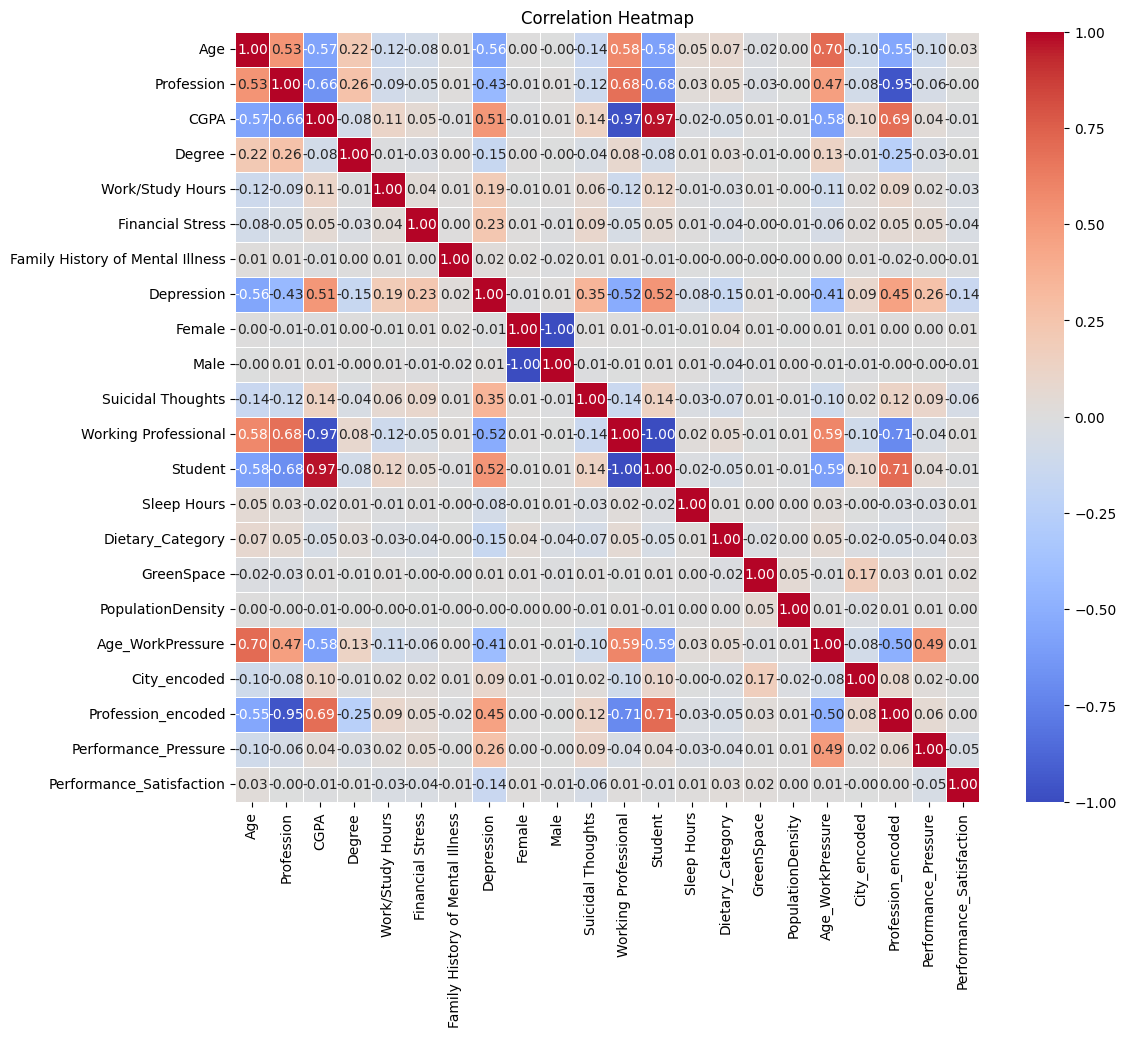

In [105]:
correlation_matrix = train_df.corr(numeric_only=True)

# 상관 행렬을 히트맵으로 시각화
plt.figure(figsize=(12, 10)) # 히트맵 크기 설정 (원하는 크기로 조절 가능)
sns.heatmap(correlation_matrix,
            annot=True, # 각 셀에 상관계수 값 표시
            cmap='coolwarm', # 색상
            fmt=".2f", # 소수점 둘째 자리까지 표시
            linewidths=.5) # 셀 경계선 두께 설정

plt.title('Correlation Heatmap') # 그래프 제목 설정
plt.show() # 그래프 표시

# 6. Modeling

## 6.1. Pipeline development

In [84]:
train_df = train_df.drop(['Working Professional or Student', 'Name', 'Gender'], axis=1)
test_df = test_df.drop(['Working Professional or Student', 'Name', 'Gender'], axis=1)


In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age                               140700 non-null  int64  
 1   City                              140700 non-null  object 
 2   Profession                        140700 non-null  int64  
 3   CGPA                              140700 non-null  int64  
 4   Degree                            140700 non-null  float64
 5   Work/Study Hours                  140700 non-null  float64
 6   Financial Stress                  140700 non-null  float64
 7   Family History of Mental Illness  140700 non-null  int64  
 8   Depression                        140700 non-null  int64  
 9   Female                            140700 non-null  int64  
 10  Male                              140700 non-null  int64  
 11  Suicidal Thoughts                 140700 non-null  i

In [86]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               93800 non-null  int64  
 1   City                              93800 non-null  object 
 2   Profession                        93800 non-null  int64  
 3   CGPA                              93800 non-null  int64  
 4   Degree                            93800 non-null  float64
 5   Work/Study Hours                  93800 non-null  float64
 6   Financial Stress                  93800 non-null  float64
 7   Family History of Mental Illness  93800 non-null  int64  
 8   Female                            93800 non-null  int64  
 9   Male                              93800 non-null  int64  
 10  Suicidal Thoughts                 93800 non-null  int64  
 11  Working Professional              93800 non-null  int64  
 12  Stud

In [87]:
train_df.head(4)

,Age,City,Profession,CGPA,Degree,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Female,...,Student,Sleep Hours,Dietary_Category,GreenSpace,PopulationDensity,Age_WorkPressure,City_encoded,Profession_encoded,Performance_Pressure,Performance_Satisfaction
0,7,Ludhiana,3,0,2.0,1.0,2.0,0,0,1,...,0,9.0,3.0,0.80,9781.0,35.0,0.192690,0.056323,5.0,2.0
1,3,Varanasi,3,0,4.0,7.0,3.0,0,1,0,...,0,4.5,1.0,24.78,2367.0,12.0,0.142206,0.056323,4.0,3.0
2,4,Visakhapatnam,0,8,2.0,3.0,1.0,0,1,0,...,1,5.5,3.0,0.18,3900.0,0.0,0.159196,0.431698,5.0,2.0
3,2,Mumbai,3,0,2.0,10.0,1.0,1,1,0,...,0,4.5,2.0,9.36,20482.0,10.0,0.131293,0.056323,5.0,1.0


In [88]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# 1. Define features and target
X_train = train_df.drop('Depression', axis=1)
y_train = train_df['Depression']

# 2. Redefine columns for preprocessing
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# 3. Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

# Categorical Pipeline (Ordinal, Constant Impute)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(
        dtype=None,                   # ⭐ 데이터 타입 지정 해제 (안정성 증가)
        handle_unknown='use_encoded_value', # ⭐ 복구: 알 수 없는 값 처리 활성화
        unknown_value=-1                   # ⭐ 복구: 알 수 없는 값은 -1로 인코딩
    ))
])

# 4. Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# 5. Apply the transformations to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(test_df)

# 6.업데이트: 전처리된 데이터를 최종 학습용과 검증용으로 분리
# (이 코드를 통해 X_train_final과 y_train_final을 모델 학습에 사용합니다.)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_preprocessed,
    y_train,
    test_size=0.2,            # 20%를 검증 데이터로 사용
    random_state=rs,
    stratify=y_train          # 타겟 변수의 비율을 유지
)

In [89]:
from sklearn.model_selection import train_test_split
# ...

# 1. 전처리 적용
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(test_df)

# 2. 훈련 데이터셋을 최종 학습용(final)과 검증용(val)으로 분리 (A 코드)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_preprocessed,
    y_train,
    test_size=0.2,            # 20%를 검증 데이터로 사용
    random_state=rs,
    stratify=y_train
)

## 6.2. Removing Outliers from Training Data using Isolation Forest

In [90]:
# Apply Isolation Forest for outlier detection on the training data
isolation_forest = IsolationForest(contamination=0.04, random_state=rs)
outlier_labels = isolation_forest.fit_predict(X_train_final)

# Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1
X_train_final = X_train_final[non_outliers_mask]
y_train_final = y_train_final[non_outliers_mask]

## 6.3. Defining Ensemble Models and Building a Stacking Classifier

In [91]:
xgb_params = {
     'learning_rate': 0.298913248058474,
     'max_depth': 9,
     'min_child_weight': 3,
     'n_estimators': 673,
     'subsample': 0.5933970249700855,
     'gamma': 2.597137534750985,
     'reg_lambda': 0.11328048420927406,
     'colsample_bytree': 0.1381203919800721
}

catboost_params = {
    'iterations': 145,
    'depth': 7,
    'learning_rate': 0.29930179265937246,
    'l2_leaf_reg': 1.242352421942431,
    'random_strength': 8.325681754379957,
    'bagging_temperature': 0.7869848919618048,
    'border_count': 139
}

hgb_params = {
    'learning_rate': 0.16299202834206894,
    'max_iter': 250,
    'max_depth': 4,
    'l2_regularization': 7.1826466833939895,
    'early_stopping': True
}

# Initialize models with pre-tuned and trial-specific parameters
xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, random_state=rs)
catboost_model = CatBoostClassifier(**catboost_params, task_type="CPU", random_state=rs, verbose=0)
hgb_model = HistGradientBoostingClassifier(**hgb_params, random_state=rs)

# Define stacking ensemble with the LightGBM model tuned in this trial
stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('hgb', hgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=False
)

In [92]:
catboost_model_test = CatBoostClassifier(**catboost_params, task_type="GPU", random_state=rs, verbose=0)

## 6.4. CATBOOST Model

In [93]:
model = CatBoostClassifier(verbose=0)
model.fit(X_train_final, y_train_final,)

In [94]:
feat_importance = model.get_feature_importance()
feat_names = X_train.columns

pd.Series(feat_importance, index=feat_names).sort_values(ascending=False)

,0
Age,22.820922
Male,13.001678
Profession_encoded,10.233782
Work/Study Hours,7.875343
Performance_Pressure,7.076004
Degree,7.027122
PopulationDensity,5.974246
Sleep Hours,4.046675
Student,2.694316
Age_WorkPressure,2.637927


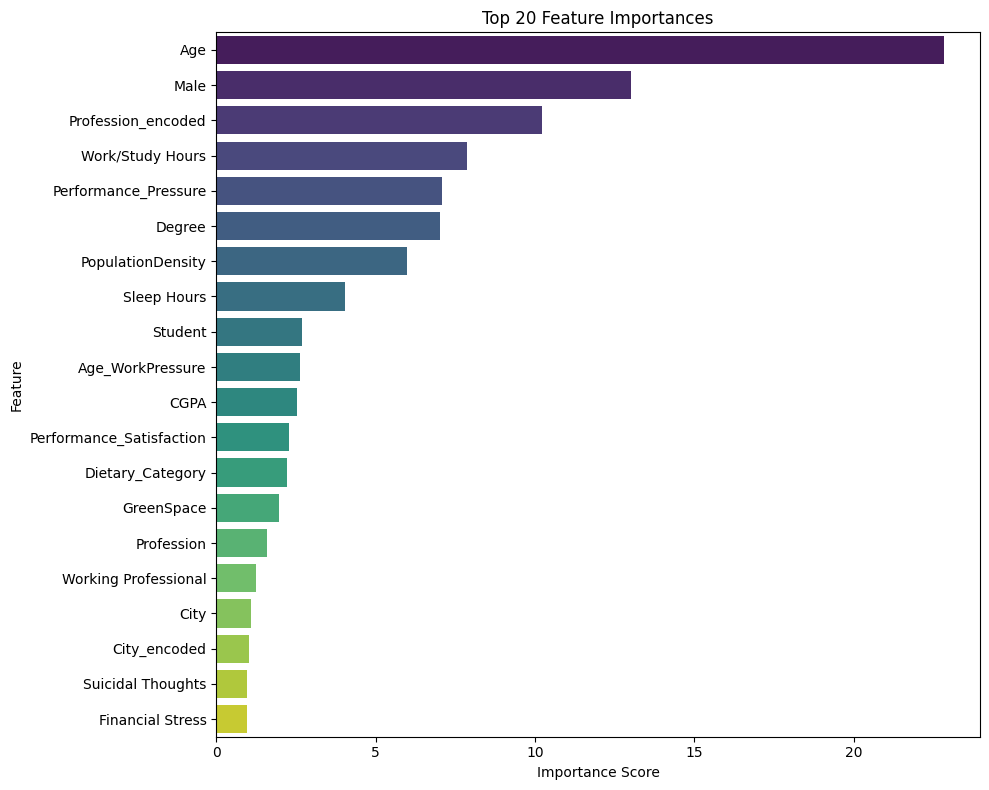

In [95]:
# prompt: feat_importance 시각화

# Get feature importance
feat_importance = model.get_feature_importance()
feat_names = X_train.columns

# Create a pandas Series for easier handling
importance_series = pd.Series(feat_importance, index=feat_names).sort_values(ascending=False)

# Visualize the top N features
top_n = 20 # Adjust N as needed
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_series.head(top_n).values, y=importance_series.head(top_n).index, palette='viridis')
plt.title(f'Top {top_n} Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [96]:
 #5-fold 교차검증으로 평가하는 코드
# Define a scoring metric
scoring = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(stacking_ensemble, X_train_final, y_train_final, cv=5, scoring=scoring)

# Print cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.94123635 0.94350361 0.94262181 0.93910509 0.94053954]
Mean CV Accuracy: 0.9414
Standard Deviation of CV Accuracy: 0.0015


## 6.5. Stackig_encsemble Model

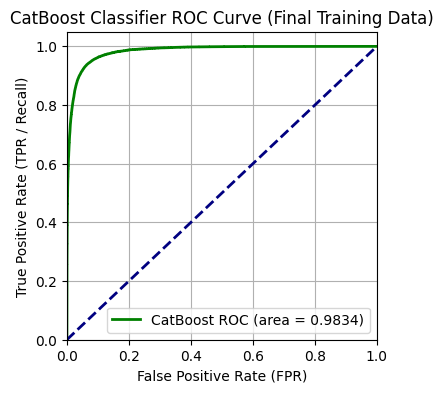

In [97]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. 모델 예측 확률 (입력: X_train_final)
y_train_proba = model.predict_proba(X_train_final)[:, 1]

# 2. ROC 곡선에 필요한 FPR, TPR 계산
# ⭐ 수정: y_train 대신 y_train_final 사용
fpr, tpr, thresholds = roc_curve(y_train_final, y_train_proba)

# 3. AUC(Area Under the Curve) 값 계산
roc_auc = auc(fpr, tpr)

# 4. 시각화 (코드 생략)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='green', lw=2, label=f'CatBoost ROC (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('CatBoost Classifier ROC Curve (Final Training Data)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

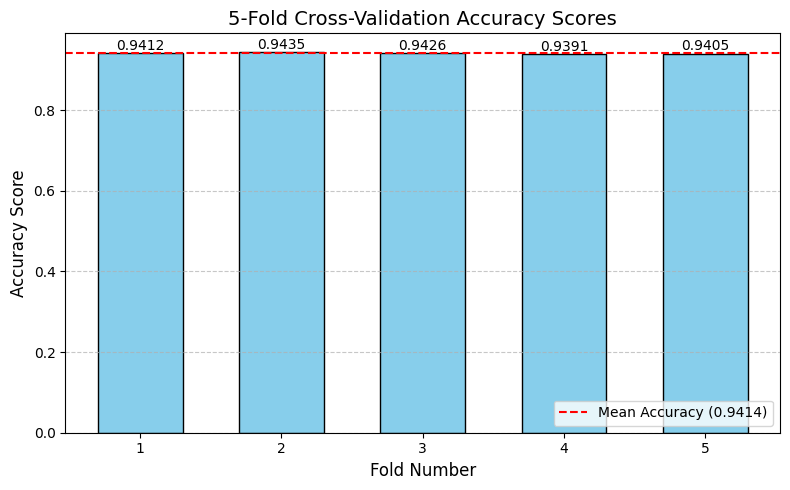

In [98]:
# cv_scores 변수는 이전 셀에서 정의되었다고 가정합니다.

plt.figure(figsize=(8, 5))
folds = np.arange(1, len(cv_scores) + 1)
mean_score = cv_scores.mean()

# 폴드별 점수를 막대 그래프로 표시
plt.bar(folds, cv_scores, color='skyblue', width=0.6, edgecolor='black')

# 평균 정확도 라인 추가
plt.axhline(mean_score, color='r', linestyle='--', linewidth=1.5, label=f'Mean Accuracy ({mean_score:.4f})')

# 각 막대 위에 점수 표시
for i, score in enumerate(cv_scores):
    plt.text(folds[i], score + 0.0005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)

plt.title('5-Fold Cross-Validation Accuracy Scores', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(folds)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('cross_validation_scores_visualization.png')

In [99]:
# 교차 검증 (평가)
cv_scores = cross_val_score(stacking_ensemble, X_train_final, y_train_final, cv=5, scoring=scoring)

# 최종 모델 학습 (Fit the model)
stacking_ensemble.fit(X_train_final, y_train_final)

# 테스트 데이터 예측
test_preds = stacking_ensemble.predict(X_test_preprocessed)

In [100]:
from sklearn.metrics import roc_auc_score, classification_report

# 검증 데이터셋에 대한 예측 확률 및 클래스 예측
val_preds = stacking_ensemble.predict(X_val)
val_proba = stacking_ensemble.predict_proba(X_val)[:, 1]

# 성능 평가 결과 출력
print("--- Validation Set Performance ---")
print(f"ROC AUC Score: {roc_auc_score(y_val, val_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_val, val_preds))

--- Validation Set Performance ---
ROC AUC Score: 0.9731

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     23027
           1       0.85      0.79      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140



In [101]:
# Fit the model
stacking_ensemble.fit(X_train_final, y_train_final)

# Make predictions
test_preds = stacking_ensemble.predict(X_train_final)

In [102]:
# A 코드가 있던 셀을 찾아서 아래 두 줄을 다시 실행합니다.
# 안전을 위해 X_train_preprocessed도 다시 만듭니다.
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(test_df)

In [103]:
# B 코드 셀을 찾아서 아래 예측 부분만 다시 실행합니다.
# ⭐️ 올바른 테스트 데이터로 예측
test_preds = stacking_ensemble.predict(X_test_preprocessed)

In [104]:
# Create a DataFrame to hold the submission results
output = pd.DataFrame({'id': test_ids,
                       'Depression': test_preds})

# Save the DataFrame to a CSV file
output.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' successfully created!")

Submission file 'submission.csv' successfully created!
